In [1]:
# Necssary libraries
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import re
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
pd.set_option('display.max_columns', 500)
%matplotlib inline
import random
import warnings

warnings.filterwarnings('ignore')

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#  Format Load Data
weather_df = pd.read_hdf(r".\Raw Data\ISONE Hourly Weather.hdf")
load_df = pd.read_hdf(r".\Raw Data\ISONE Hourly Load.hdf")
ws_info = pd.DataFrame(weather_df.groupby(["Weather Station Name","State","County"]).count()["Wind Speed Knots"]).reset_index()[["Weather Station Name","State","County"]]
lz_info = pd.DataFrame(load_df["Load Region"].unique(),columns=["Load Zone"])
load_zones = lz_info["Load Zone"].iloc[:8].values
load_df = (load_df.groupby(["Local Datetime (Hour Beginning)","Load Region"]).mean()["Load MW"].reset_index()).pivot(index="Local Datetime (Hour Beginning)",columns="Load Region",values="Load MW")[load_zones]
load_df["ISONE"] = load_df.sum(axis=1)
load_df = load_df.loc[np.isfinite(load_df["ISONE"])]


# Mapping Weather Locations to Load Zones

Before determining the feature set of data which can provide explanatory power in demand forecasting, we need to be able to map the various load zones to relevant weather stations.

We accomplish this buy showing a scatter plot between Avg Dry Bulb Temperature across weather stations and Total New England Load; then by running a ridge regression on the various locational Dry Bulb Temperature

In [3]:
lz_info.loc[:7]

,Load Zone
0,.Z.CONNECTICUT
1,.Z.MAINE
2,.Z.NEMASSBOST
3,.Z.NEWHAMPSHIRE
4,.Z.RHODEISLAND
5,.Z.SEMASS
6,.Z.VERMONT
7,.Z.WCMASS


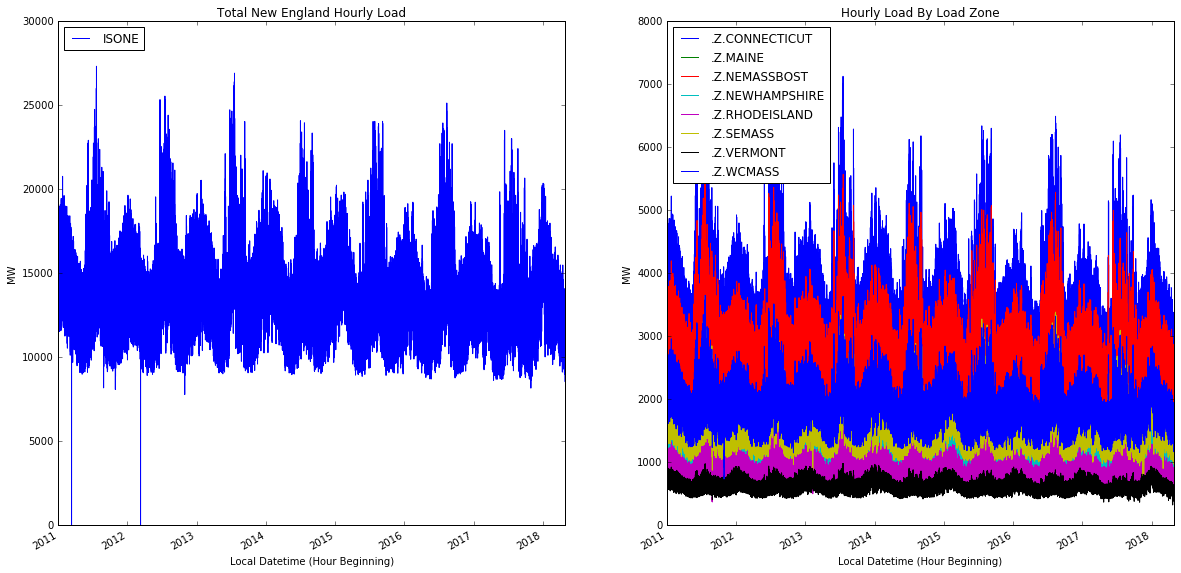

,Weather Station Name,State,County
0,Bangor Intl Arpt,ME,Penobscot
1,Bedford Hanscom Field,MA,Middlesex
2,Berlin Municipal Arpt,NH,Coos
3,Beverly Municipal Arpt,MA,Essex
4,Boston Logan Intl Arpt,MA,Suffolk
5,Bridgeport/Igor Sikorsky Memorial,CT,Fairfield
6,Burlington Intl Arpt,VT,Chittenden
7,Concord Municipal Arpt,NH,Merrimack
8,Danbury Municipal Arpt,CT,Fairfield
9,Hartford Brainard Arpt,CT,Hartford


In [4]:
# Map Weather Station to Load Zone
#(load_df["ISONE"]).plot()
fig,ax = plt.subplots(1,2,figsize=(20,10))
load_df["ISONE"].plot(ax=ax[0])
load_df[load_df.columns[:-1]].plot(ax=ax[1])
ax[0].legend(loc=2)
ax[1].legend(loc=2)
ax[0].set_title("Total New England Hourly Load")
ax[0].set_ylabel("MW")                                   
ax[1].set_title("Hourly Load By Load Zone")
ax[1].set_ylabel("MW")                                   
plt.show()

ws_info

If we compute the arithmatic average of hourly temperatures across all weather stations, we will clearly see a relationship between the temperature and load, which is non-linear in nature and not well captured by correlation.  However, we can use this relationship to develop a "mapping" between the various weather stations and load zones.  Once we can identify this "mapping", we can continue with the feature selection.  The goal here is to forecast the demand at the load zone level.

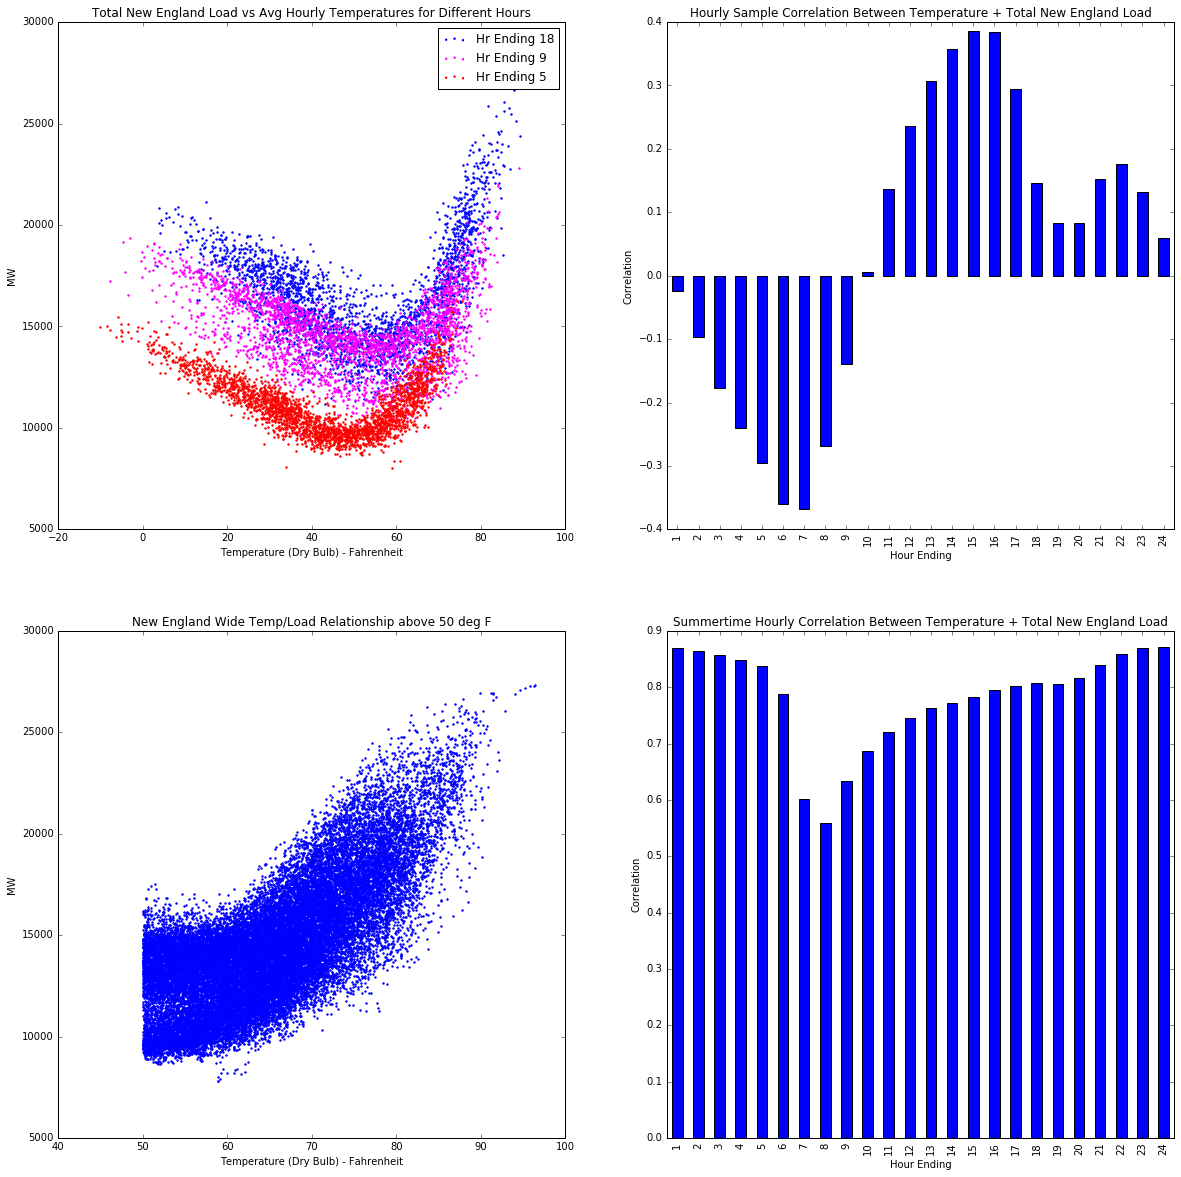

In [5]:
avg_temps = weather_df.groupby("Local Datetime (Hour Beginning)").mean()["Temperature (Dry Bulb) - Fahrenheit"]
ne_load_tmp = pd.DataFrame(load_df["ISONE"])
ne_load_tmp = ne_load_tmp.join(avg_temps,how="inner")
ne_load_tmp["HE"]  = ne_load_tmp.index.hour + 1
ne_load_tmp_he18 = ne_load_tmp.loc[ne_load_tmp["HE"] == 18]
ne_load_tmp_he9 = ne_load_tmp.loc[ne_load_tmp["HE"] == 9]
ne_load_tmp_he5 = ne_load_tmp.loc[ne_load_tmp["HE"] == 5]
#plt.figure(figsize=(8,8))
fig,ax = plt.subplots(2,2,figsize=(20,20))
ax[0,0].scatter(ne_load_tmp_he18["Temperature (Dry Bulb) - Fahrenheit"],ne_load_tmp_he18["ISONE"],label="Hr Ending 18",color="blue",s=2)
ax[0,0].scatter(ne_load_tmp_he9["Temperature (Dry Bulb) - Fahrenheit"],ne_load_tmp_he9["ISONE"],label="Hr Ending 9",color="magenta",s=2)
ax[0,0].scatter(ne_load_tmp_he5["Temperature (Dry Bulb) - Fahrenheit"],ne_load_tmp_he5["ISONE"],label="Hr Ending 5",color="red",s=2)
ax[0,0].set_xlabel("Temperature (Dry Bulb) - Fahrenheit")
ax[0,0].set_ylabel("MW")
ax[0,0].set_title("Total New England Load vs Avg Hourly Temperatures for Different Hours")
ax[0,0].legend(loc="best")



corr_df = (ne_load_tmp.groupby("HE").corr()["ISONE"]).reset_index()
corr_df = corr_df.loc[corr_df["level_1"]=="Temperature (Dry Bulb) - Fahrenheit"]
hrly_corr = corr_df.groupby("HE").mean()["ISONE"]
hrly_corr.name = "Corr Between Temp and Load"
hrly_corr.plot(kind='bar',title="Hourly Sample Correlation Between Temperature + Total New England Load",ax=ax[0,1])
ax[0,1].set_xlabel("Hour Ending")
ax[0,1].set_ylabel("Correlation")


ne_load_tmp_above50 = ne_load_tmp.loc[ne_load_tmp["Temperature (Dry Bulb) - Fahrenheit"] > 50.0]
ax[1,0].scatter(ne_load_tmp_above50["Temperature (Dry Bulb) - Fahrenheit"],ne_load_tmp_above50["ISONE"],color="blue",s=2)
ax[1,0].set_xlabel("Temperature (Dry Bulb) - Fahrenheit")
ax[1,0].set_ylabel("MW")
ax[1,0].set_title("New England Wide Temp/Load Relationship above 50 deg F")

corr_df50 = (ne_load_tmp_above50.groupby("HE").corr()["ISONE"]).reset_index()
corr_df50 = corr_df50.loc[corr_df50["level_1"]=="Temperature (Dry Bulb) - Fahrenheit"]
hrly_corr50 = corr_df50.groupby("HE").mean()["ISONE"]
hrly_corr50.name = "Corr Between Temp and Load"
hrly_corr50.plot(kind='bar',title="Summertime Hourly Correlation Between Temperature + Total New England Load",ax=ax[1,1])
ax[1,1].set_xlabel("Hour Ending")
ax[1,1].set_ylabel("Correlation")
plt.show()

Because of this non-linear relationship, to find the most suitable weather station for each load zone is challenging.  We need to isolate an area where the temp-load relationship is closer to linear.  If we filter based on summer temperatures (above 50 deg F), a linear regression would likely be more succesful in predicting the demand than if we estimated summer/winter together. 

Thus, we can use a regularized regression between the Load Zone specific demand and weather station hourly temperature to determine which weather stations are relevant to loacational demand.

Analysis into the data shows that Pittsfield Municipal Airport is only available since 2015, so we can exclude that station and proceed with the data points where all Dry Bulb Temps + Load Zone Demand Numbers are valid.

In [6]:
wstation_temps = \
weather_df.groupby(["Local Datetime (Hour Beginning)", "Weather Station Name"]).mean()["Temperature (Dry Bulb) - Fahrenheit"]
wstation_temps = \
(wstation_temps.reset_index()).pivot(index="Local Datetime (Hour Beginning)",columns="Weather Station Name",values="Temperature (Dry Bulb) - Fahrenheit")






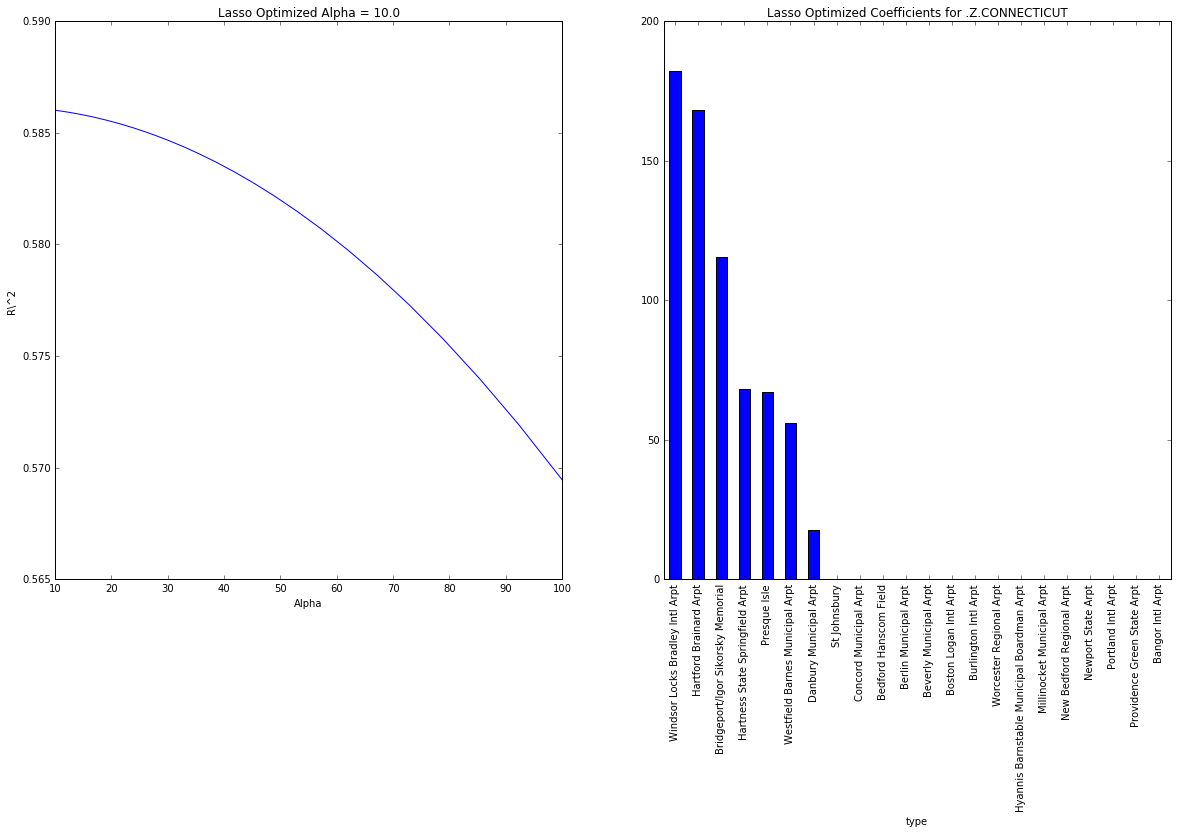

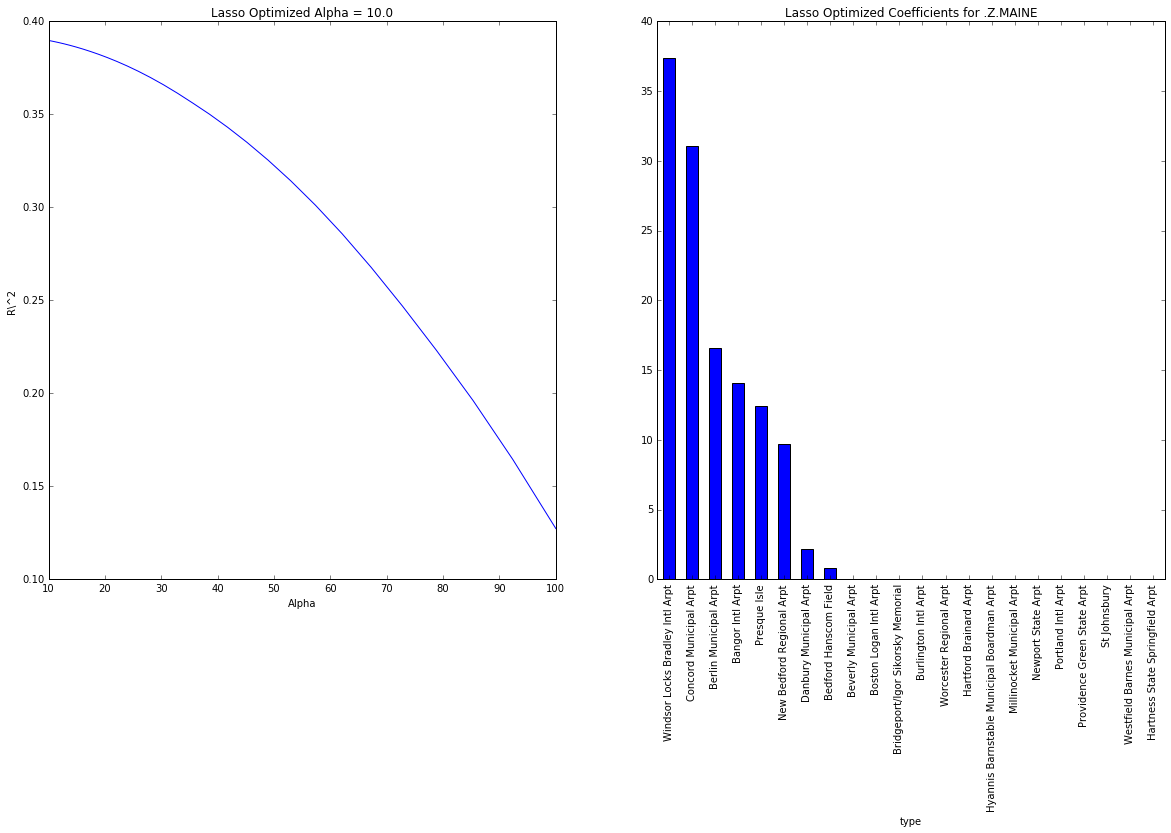

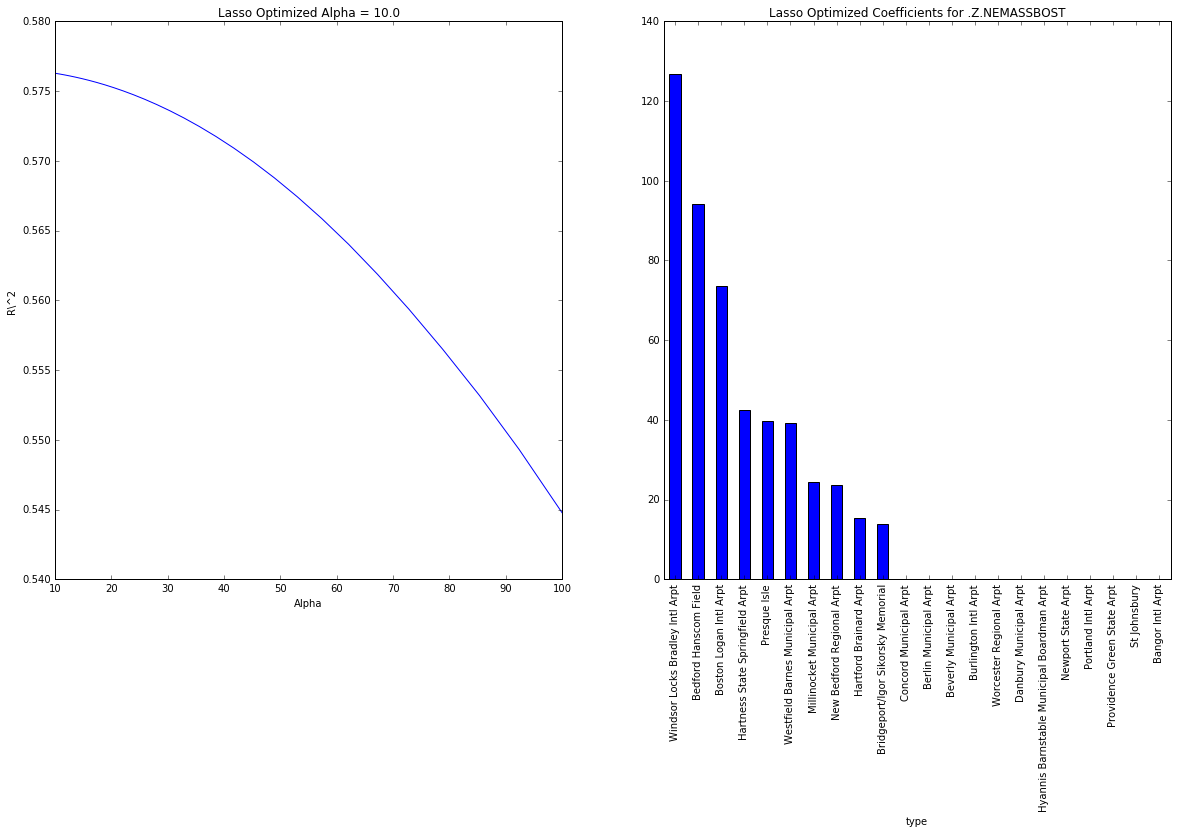

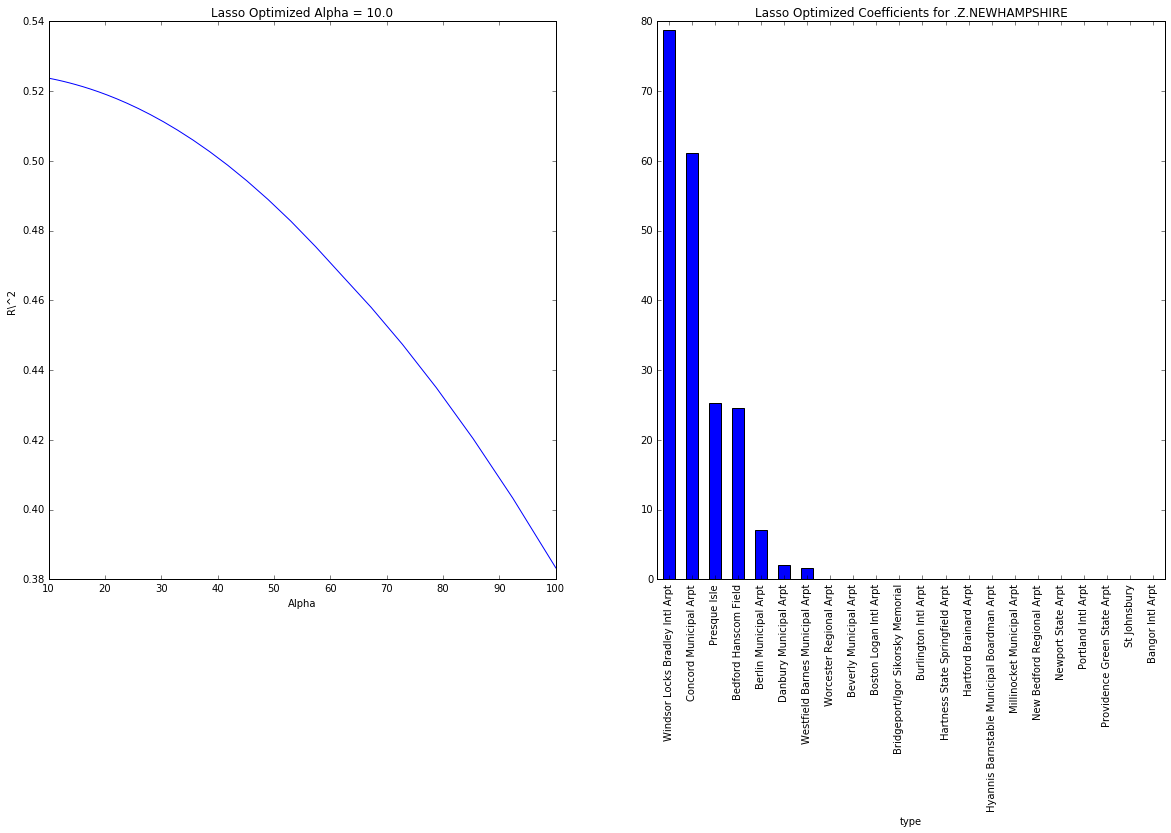

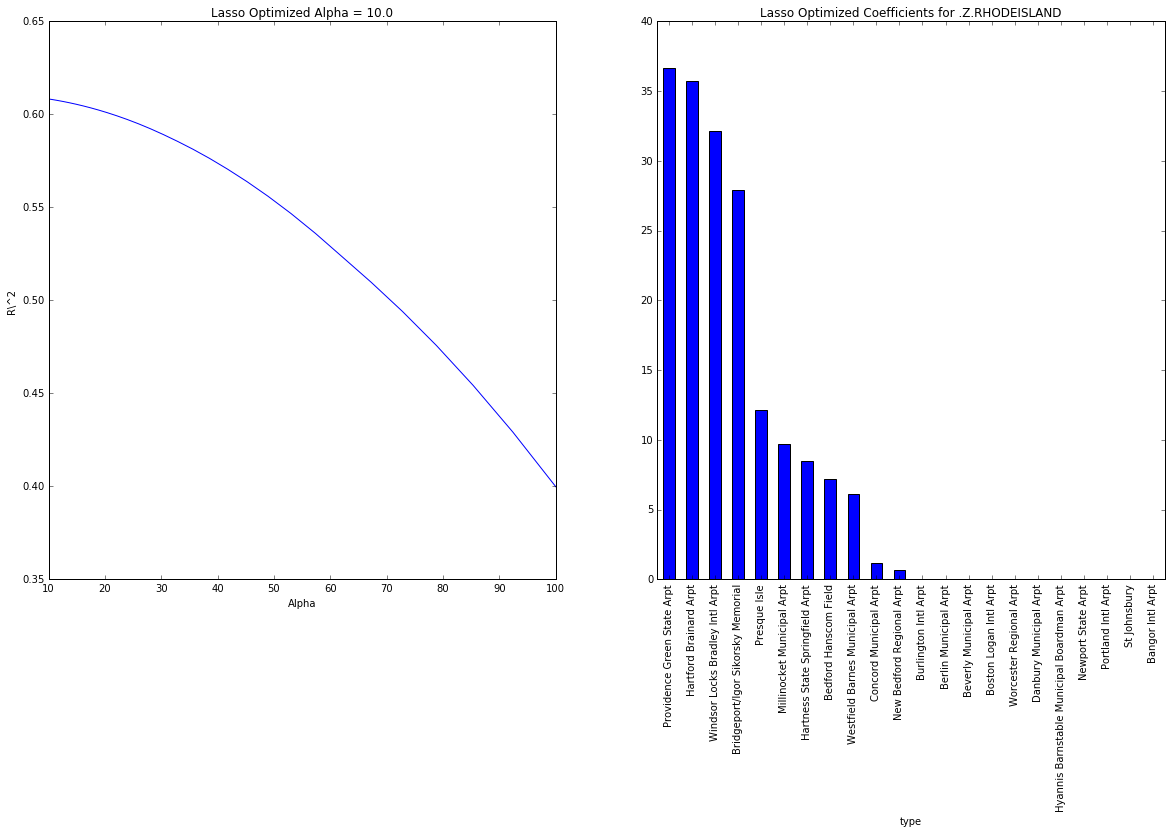

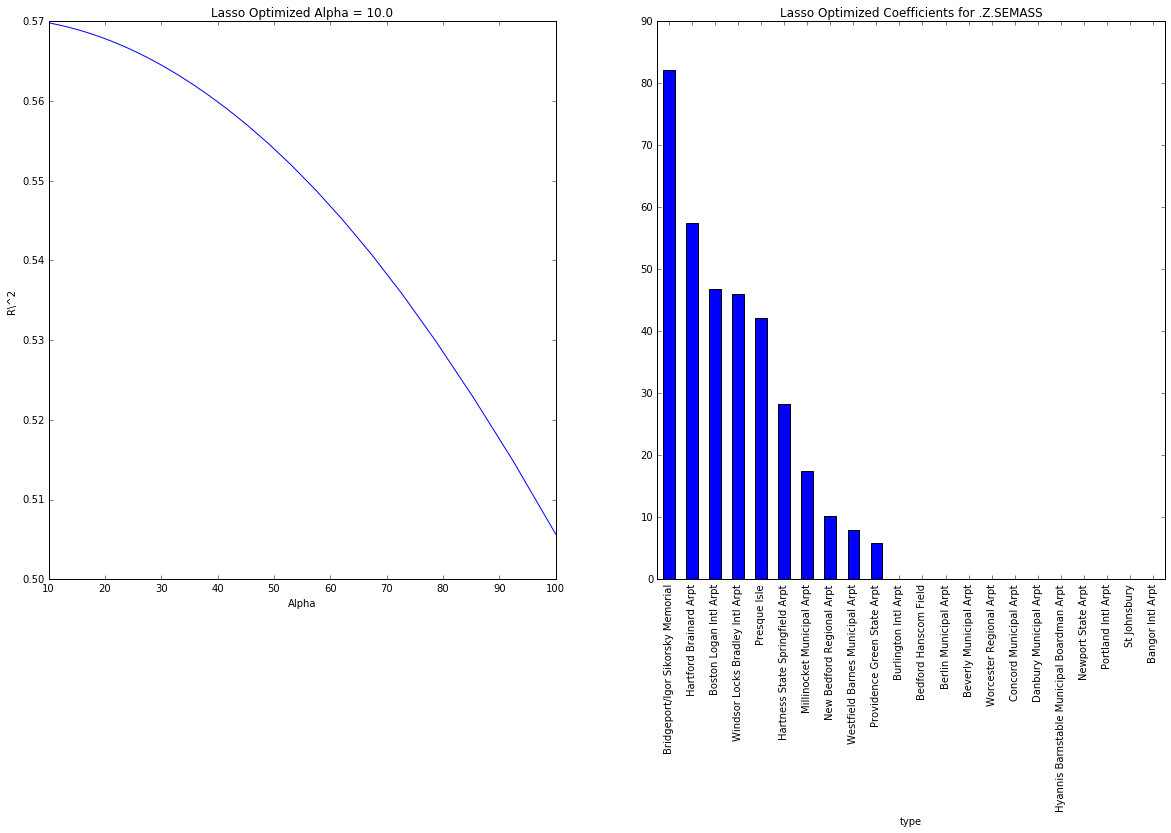

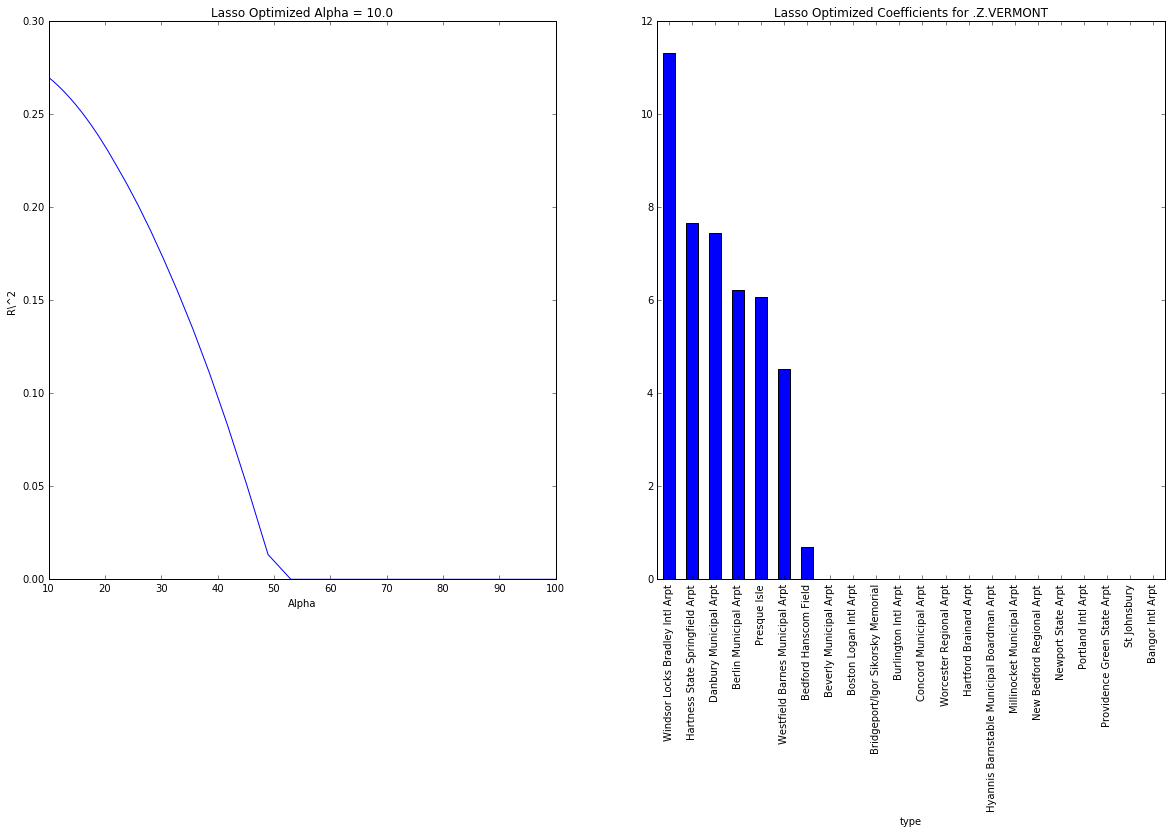

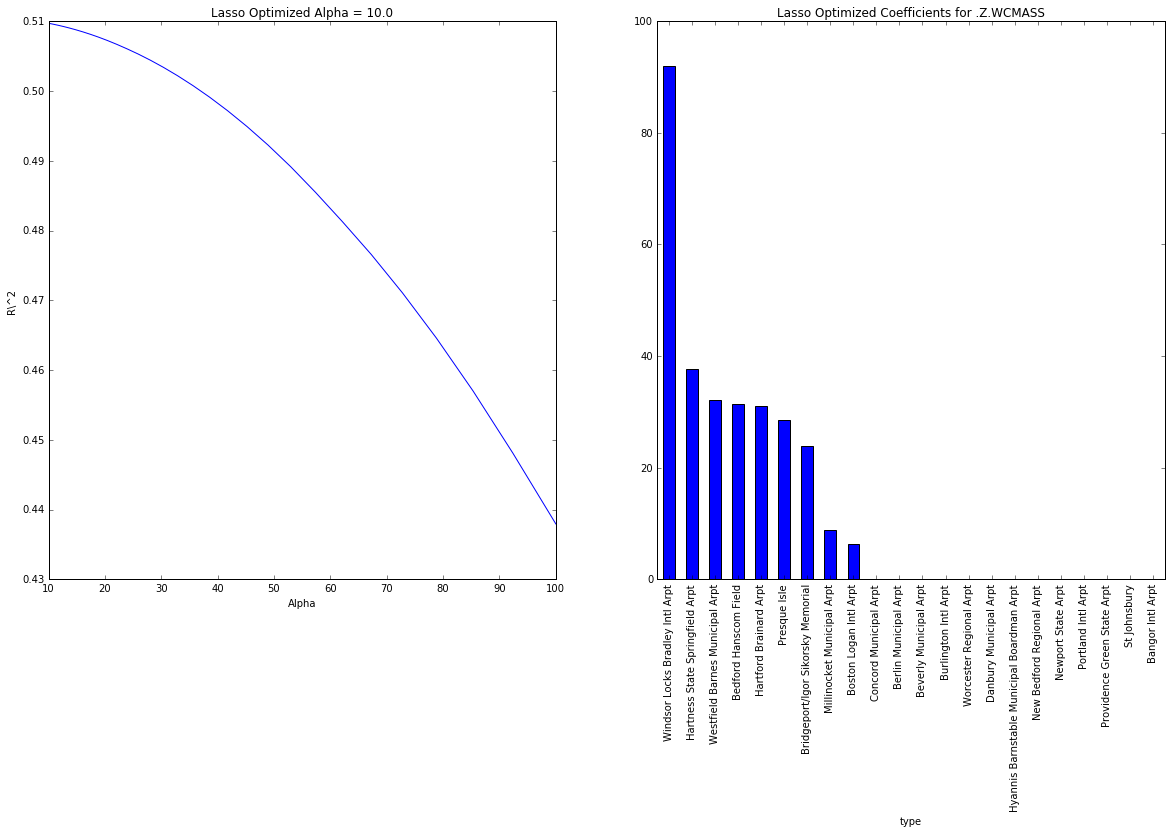

In [7]:
lz_ws_mapping = pd.DataFrame(index=ws_info["Weather Station Name"].values)
lz_ws_mapping["State"] = ws_info["State"].values

for lz in load_zones:
    fig,ax = plt.subplots(1,2,figsize=(20,10))
    #r = np.where(load_zones == lz)[0][0]
    lz_df = pd.DataFrame(load_df[lz]).join(wstation_temps,how="inner")
    lz_df=lz_df[lz_df.columns[np.isfinite(lz_df).sum(axis=0) > 60.0e3]]
    lz_df=lz_df[np.isfinite(lz_df).all(axis=1)]
    #lz_df = lz_df.loc[lz_df.index.hour == 18]
    lz_df_summer = lz_df.loc[lz_df[lz_df.columns[1:]].mean(axis=1) > 50.0]

    alphas = np.logspace(1,2,30)

    scores = []
    scaler = StandardScaler()
    #lz_df_summer[lz_df_summer.columns[1:]]
    X = scaler.fit_transform(lz_df_summer[lz_df_summer.columns[1:]])
    y = lz_df_summer[lz]

    for _alpha in alphas:
        regr = Lasso(alpha=_alpha)
        regr.fit(X,y)
        rsq = regr.score(X,y)
        scores.append(rsq)

    alpha_best = alphas[np.argmax(scores)]
    #print("Alpha Best : {}".format(alpha_best))

    ax[0].plot(alphas,scores)
    ax[0].set_xlabel("Alpha")
    ax[0].set_ylabel("R\^2")
    ax[0].set_title("Lasso Optimized Alpha = {}".format(alpha_best))
    

    regr = Lasso(alpha=alpha_best)
    # Train the model using the training sets
    regr.fit(X,y)
    #regr.coef_
    dfCoeffs = pd.DataFrame({'type':lz_df_summer.columns[1:], 'coef':regr.coef_})


    dfCoeffs2 = dfCoeffs.groupby('type')['coef'].mean()

    dfCoeffs2 = dfCoeffs2.sort_values()
    dfCoeffs2[::-1].plot(kind='bar',title="Lasso Optimized Coefficients for {}".format(lz),ax=ax[1])
    
    lz_ws_mapping[lz] = 0.0
    wgts = dfCoeffs2[::-1][:3] / dfCoeffs2[::-1][:3].sum()
    for w in wgts.index:
        lz_ws_mapping.loc[w,lz] = wgts.loc[w]
    plt.show()

lz_ws_mapping.index.name = "Weather Station Weight"


In [8]:
lz_ws_mapping

,State,.Z.CONNECTICUT,.Z.MAINE,.Z.NEMASSBOST,.Z.NEWHAMPSHIRE,.Z.RHODEISLAND,.Z.SEMASS,.Z.VERMONT,.Z.WCMASS
Weather Station Weight,,,,,,,,,
Bangor Intl Arpt,ME,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Bedford Hanscom Field,MA,0.000000,0.000000,0.319447,0.000000,0.000000,0.000000,0.000000,0.000000
Berlin Municipal Arpt,NH,0.000000,0.195274,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Beverly Municipal Arpt,MA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Boston Logan Intl Arpt,MA,0.000000,0.000000,0.250299,0.000000,0.000000,0.251361,0.000000,0.000000
Bridgeport/Igor Sikorsky Memorial,CT,0.247891,0.000000,0.000000,0.000000,0.000000,0.440683,0.000000,0.000000
Burlington Intl Arpt,VT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Concord Municipal Arpt,NH,0.000000,0.365415,0.000000,0.370343,0.000000,0.000000,0.000000,0.000000
Danbury Municipal Arpt,CT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.281749,0.000000


# Feature Identification And Variable Selection

## Seasonality + Hourly Dependance

We have clearly shown a dependance between basic Dry Bulb Temperatures and Demand.  However, we notice that there are also seasonal + hourly dependancies.  We attempt now to qualitiatively show this dependance and then formally incorporate them as variables.  The factors we look at here are calendar month, time (as load can grow over time), the hour, and the day of the week.

We plot the conditional mean alongside the 25th and 75th %-iles to show a general dependance.  We want to makes sure that the factors in our model generally make sense.

In [9]:
ne_load_tmp["Calendar Month"] = ne_load_tmp.index.month
ne_load_tmp["Year"] = ne_load_tmp.index.year
ne_load_tmp["Day of Week"] = ne_load_tmp.index.dayofweek

# days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}

# ne_load_tmp["Day of Week"] = ne_load_tmp["Day of Week"].apply(lambda x: days[x])

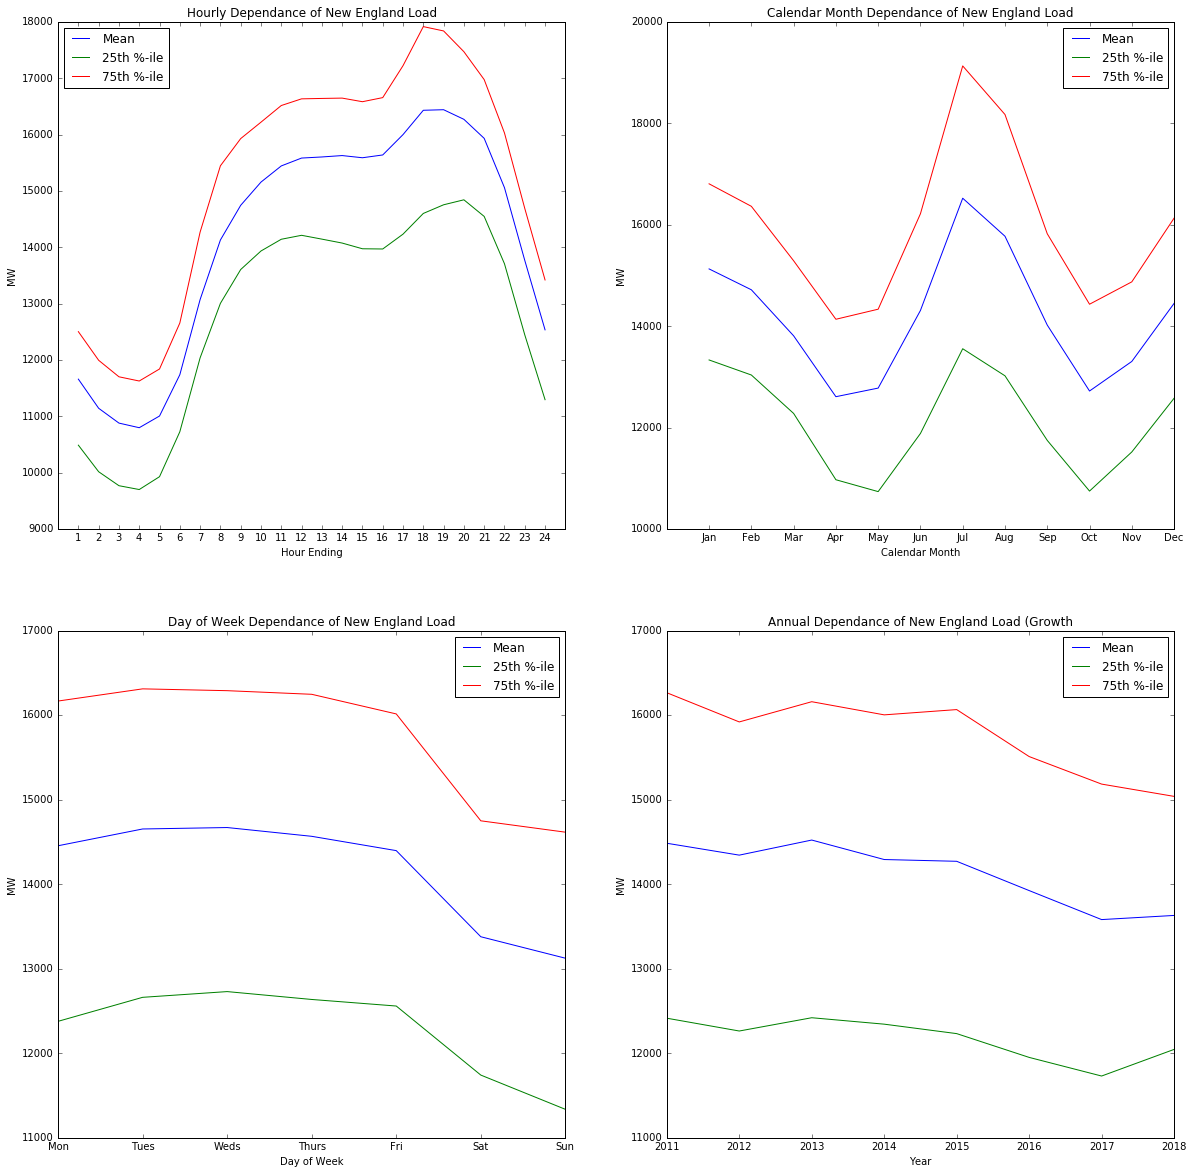

In [10]:
fig,ax = plt.subplots(2,2,figsize=(20,20))
ax[0,0].plot(ne_load_tmp.groupby("HE").mean()["ISONE"],label="Mean")
ax[0,0].plot(ne_load_tmp.groupby("HE").quantile(.25)["ISONE"],label="25th %-ile")
ax[0,0].plot(ne_load_tmp.groupby("HE").quantile(.75)["ISONE"],label="75th %-ile")
ax[0,0].set_title("Hourly Dependance of New England Load")
ax[0,0].set_xticks(range(1,25))
ax[0,0].set_xlabel("Hour Ending")
ax[0,0].set_ylabel("MW")
ax[0,0].legend(loc="best")

ax[0,1].plot(ne_load_tmp.groupby("Calendar Month").mean()["ISONE"],label="Mean")
ax[0,1].plot(ne_load_tmp.groupby("Calendar Month").quantile(.25)["ISONE"],label="25th %-ile")
ax[0,1].plot(ne_load_tmp.groupby("Calendar Month").quantile(.75)["ISONE"],label="75th %-ile")
ax[0,1].set_title("Calendar Month Dependance of New England Load")
ax[0,1].set_xticks(range(1,13))
ax[0,1].set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])                   
ax[0,1].set_xlabel("Calendar Month")
ax[0,1].set_ylabel("MW")
ax[0,1].legend(loc="best")



ax[1,1].plot(ne_load_tmp.groupby("Year").mean()["ISONE"],label="Mean")
ax[1,1].plot(ne_load_tmp.groupby("Year").quantile(.25)["ISONE"],label="25th %-ile")
ax[1,1].plot(ne_load_tmp.groupby("Year").quantile(.75)["ISONE"],label="75th %-ile")
ax[1,1].set_title("Annual Dependance of New England Load (Growth")
ax[1,1].set_xlabel("Year")
ax[1,1].set_xticklabels(ne_load_tmp["Year"].unique())

ax[1,1].set_ylabel("MW")
ax[1,1].legend(loc="best")
ne_load_tmp.groupby("Day of Week").mean()["ISONE"].plot(label="Mean",ax=ax[1,0])
ne_load_tmp.groupby("Day of Week").quantile(.25)["ISONE"].plot(label="25th %-ile",ax=ax[1,0])
ne_load_tmp.groupby("Day of Week").quantile(.75)["ISONE"].plot(label="75th %-ile",ax=ax[1,0])
ax[1,0].set_xticks(range(7))
ax[1,0].set_xticklabels(['Mon','Tues','Weds','Thurs','Fri','Sat','Sun'])
ax[1,0].set_xlabel("Day of Week")
ax[1,0].set_ylabel("MW")
ax[1,0].set_title("Day of Week Dependance of New England Load")
ax[1,0].legend(loc="best")

plt.show()

We should definately consider variables reflecting the Hour, Weekday/Weekend, and Calendar Month/Time of Year.  We dont see strong evidence yet of Load growth at the New England ISO level.

## Weather Variables

There are many different types of weather variables we could consider.  However, we are restricted by the type of forecast data available to us.  Our historical data set will provide us with hourly data for Dry Bulb Temperatures, Dew Point Temperatures Cloud Cover, Precip, Sky Conditions and Preceip Conditions in Text Variables.  Many other variables are also provided.



In [11]:
weather_df.head()

,Local Datetime (Hour Beginning),Temperature (Dry Bulb) - Fahrenheit,Heat Index Temperature - Fahrenheit,Wind Chill Temperature - Fahrenheit,Dew Point Temperature - Fahrenheit,Weather Station Name,Station Call ID,State,County,Time Zone,Relative Humidity Percent,Wind Speed mph,Wind Direction,Wind Gust mph,Total Precipitation (inches),"Weather Conditions (Rain, Ice, Thunderstorms, etc)",Altimeter Pressure inches of Mercury,Record Count,Average Precipitation (inches),Thunderstorm,Freezing Precipitation,Rain,Snow,Hail/ Ice,Obscuration,Sky Condition,Sky Condition code,Cloud Cover %,Cloud Ceiling Height (ft),Station Pressure - millibars,Station Pressure inches of Mercury,Pressure Tendency,Wind Speed Knots,Wind Speed m/s,Wind Direction Degrees North,Maximum Wind Gust mph,Wind Gust Knots,Wind Gust m/s,Avg Wind Power Density (watts/ sq meter),Sum Wind Power Density (watts/ sq meter),Air Density (kg/ cubic meter),Max Temperature (Dry Bulb) - Fahrenheit,Min Temperature (Dry Bulb) - Fahrenheit,Temperature (Dry Bulb) - Celsius,Temperature (Wet Bulb) - Fahrenheit,Temperature (Wet Bulb) - Celsius,Dew Point Temperature - Celsius,Max Heat Index Temperature - Fahrenheit,Min Wind Chill Temperature - Fahrenheit,Normal Monthly Maximum Temperature (1981-2010),Normal Monthly Minimum Temperature (1981-2010),Normal Monthly Average Temperature (1981-2010),Local Datetime (Hour Ending),GMT Datetime (Hour Beginning),Year,Quarter,Month,Date,Hour (Hour Beginning),Year-Month,Year-Week,Day of Week,Day of Year,On Peak/Off Peak - EAST,On Peak/Off Peak - WEST,On Peak/Off Peak - MIDWEST,On Peak/Off Peak - ERCOT,Station Elevation,Country,Weather Station ID
0,2011-01-01,27.0,27.0,27.000000,25.0,Concord Municipal Arpt,KCON,NH,Merrimack,EST,92.0,0.000000,Variable or No Wind,NaN,NaN,Mist,30.02,1,NaN,NaN,NaN,NaN,NaN,NaN,Mist,Few Clouds at 9000 ft,FEW090,25.0,NaN,1004.060265,29.65,Decreasing,0.0,0.000000,NaN,NaN,NaN,NaN,0.00000,0.00000,1.294437,27.0,27.0,-2.777777,26.0,-3.333333,-3.888888,27.0,27.000000,30.8,10.4,20.6,1/1/2011 01:00,1/1/2011 05:00,2011,1,1,1/1/2011 00:00,0,2011-01,2011-01,Saturday,1,Off Peak,Off Peak,Off Peak,Off Peak,346,United States of America,611622
1,2011-01-01,30.0,30.0,30.000000,28.0,Hartness State Springfield Arpt,KVSF,VT,Windsor,EST,92.0,0.000000,Variable or No Wind,NaN,NaN,Mist,30.04,1,NaN,NaN,NaN,NaN,NaN,NaN,Mist,Broken Clouds at 2600 ft,BKN026,75.0,2600.0,996.271601,29.42,Steady,0.0,0.000000,NaN,NaN,NaN,NaN,0.00000,0.00000,1.276523,30.0,30.0,-1.111111,29.0,-1.666666,-2.222222,30.0,30.000000,29.3,9.8,19.5,1/1/2011 01:00,1/1/2011 05:00,2011,1,1,1/1/2011 00:00,0,2011-01,2011-01,Saturday,1,Off Peak,Off Peak,Off Peak,Off Peak,577,United States of America,612134
2,2011-01-01,30.0,30.0,30.000000,29.0,St Johnsbury,K1V4,NH,Grafton,EST,96.0,NaN,Variable or No Wind,NaN,0.02,NaN,30.00,1,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,NaN,NaN,990.514764,29.25,Decreasing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.269147,30.0,30.0,-1.111111,30.0,-1.111111,-1.666666,30.0,30.000000,27.1,6.4,16.7,1/1/2011 01:00,1/1/2011 05:00,2011,1,1,1/1/2011 00:00,0,2011-01,2011-01,Saturday,1,Off Peak,Off Peak,Off Peak,Off Peak,697,United States of America,612135
3,2011-01-01,31.0,31.0,27.576084,27.0,Westfield Barnes Municipal Arpt,KBAF,MA,Hampden,EST,85.0,3.452338,South-Southwest,NaN,NaN,Mist,30.07,1,NaN,NaN,NaN,NaN,NaN,NaN,Mist,Broken Clouds at 12000 ft,BKN120,75.0,12000.0,1008.462552,29.78,Decreasing,3.0,1.543332,200.0,NaN,NaN,NaN,2.37013,2.37013,1.289508,31.0,31.0,-0.555555,30.0,-1.111111,-2.777777,31.0,27.576084,32.9,12.9,22.9,1/1/2011 01:00,1/1/2011 05:00,2011,1,1,1/1/2011 00:00,0,2011-01,2011-01,Saturday,1,Off Peak,Off Peak,Off Peak,Off Peak,271,United States of America,611639
4,2011-01-01,31.0,31.0,31.000000,28.0,Portland Intl Arpt,KPWM,ME,Cumberland,EST,89.0,0.000000,Variable or No Wind,NaN,NaN,NaN,30.00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clear,CLR,0.0,NaN,1013.542115,29.93,Decreasing,0.0,0.000000,NaN,NaN,NaN,NaN,0.00000,0.00000,1.296003,31.0,31.0,-0.555555,30.0,-1.111111,-2.222222,31.0,31.0

Our forecast data set would provide only a few of these variables.  Therefore, we are going to limit our variable investigations to ones that are cleanly presented in both data sets.  

We will thus consider:
- Hourly Dry Bulb Temperature
- Hourly Heat Index Temperature (Dry Bulb adj for Relative Humidity - which is calculated using Dew Point Temp)
- Hourly Wind Chill Temperature (Dry Bulb adj for Wind Speed).
- Categorical Variable indicating the Sky Condition/Cloud Cover (Clear, Few Clouds, Broken, Overcast) and handle missing data.
- Categorical Variable indicating the Type of Preciptation (Rain or Snow)
- General Bucket of How much precipitation is there (if Rain or Snow)

Wind Chill Temp:
https://www.weather.gov/media/epz/wxcalc/windChill.pdf

Heat Index Temp:
https://www.weather.gov/media/epz/wxcalc/heatIndex.pdf


For each load zone, we will take the weighted average of these temperatures at various weather stations using the scalars we derived above (proportionally adjusted for availability).  For categorical variables, we will use them in order of their scalar weight/availability.


We can then standardize and run a regularized regression to determine the significance in forecasting load zone demand.





In [12]:
temp_cols = ["Temperature (Dry Bulb) - Fahrenheit","Heat Index Temperature - Fahrenheit","Wind Chill Temperature - Fahrenheit"]
#lz = '.Z.NEMASSBOST'

for lz in load_zones:
    regr_df_lz = pd.DataFrame(load_df[lz])
    wstation_wgt = lz_ws_mapping.loc[lz_ws_mapping[lz] > .01,lz]
    agg_temp_df = pd.DataFrame(index=regr_df_lz.index,columns=temp_cols,data=0.0,dtype=float)
    agg_temp_df["Weight"] = 0.0

    for ws in wstation_wgt.index:
        ws_wgt = wstation_wgt.loc[ws]
        wsdata = weather_df.loc[weather_df["Weather Station Name"] == ws]
        wsdata = wsdata.groupby(regr_df_lz.index.name).mean()[temp_cols]
        ws_contrib = wsdata[temp_cols]*ws_wgt
        ws_contrib = ws_contrib.loc[np.isfinite(ws_contrib).all(axis=1)]
        agg_index = agg_temp_df.index
        agg_index = agg_index[np.in1d(agg_index,ws_contrib.index)]
        ws_contrib = ws_contrib.loc[agg_index]
        agg_temp_df.loc[agg_index,"Weight"] += ws_wgt    
        agg_temp_df.loc[agg_index,temp_cols] += ws_contrib.copy()

    agg_temp_df = agg_temp_df.loc[agg_temp_df["Weight"] > 0.0]
    w_scale = np.array(agg_temp_df["Weight"].values,dtype=float)
    agg_temp_df = (agg_temp_df[temp_cols].divide(w_scale,axis=0))[temp_cols]

    # Ensure all Points are Finite and that Load is 
    regr_df_lz = regr_df_lz.join(agg_temp_df,how="inner")
    regr_df_lz = regr_df_lz.loc[np.isfinite(regr_df_lz).all(axis=1)]

    ws = wstation_wgt.argmax()
    wsdata = weather_df.loc[weather_df["Weather Station Name"] == ws]

    #  Sky condition / Cloud Coveer
    sky_cond = pd.DataFrame(wsdata.groupby(regr_df_lz.index.name).first()[["Sky Condition","Sky Condition code"]])
    sky_cond["Sky Condition Variable"] = ""
    sky_cond.loc[sky_cond["Sky Condition code"].str.contains("VV",case=False) == True,"Sky Condition Variable"] = "Vertical Visibility Ltd."
    sky_cond.loc[sky_cond["Sky Condition code"].str.contains("FEW",case=False) == True,"Sky Condition Variable"] = "Few Clouds"
    sky_cond.loc[sky_cond["Sky Condition code"].str.contains("SCT",case=False) == True,"Sky Condition Variable"] = "Scattered"
    sky_cond.loc[sky_cond["Sky Condition code"].str.contains("BKN",case=False) == True,"Sky Condition Variable"] = "Broken"
    sky_cond.loc[sky_cond["Sky Condition code"].str.contains("OV",case=False) == True,"Sky Condition Variable"] = "Overcast"
    sky_cond.loc[sky_cond["Sky Condition code"].str.contains("M",case=False) == True,"Sky Condition Variable"] = "Missing"
    sky_cond.loc[sky_cond["Sky Condition code"].str.contains("CLR",case=False) == True,"Sky Condition Variable"] = "Clear"
    sky_cond.loc[sky_cond["Sky Condition Variable"] == "","Sky Condition Variable"] = "Missing"
    sky_cond = sky_cond["Sky Condition Variable"].copy()
    sky_cond.name = "Sky Condition Indicator"
    regr_df_lz = regr_df_lz.join(sky_cond,how="inner")

    #  Rain or Snow
    rain_snow = pd.DataFrame(wsdata.groupby(regr_df_lz.index.name).first()[["Rain","Snow"]])
    rain_snow["Rain Indicator"] = "No Rain"
    rain_snow.loc[rain_snow["Rain"].str.contains("Rain",case=False)== True,"Rain Indicator"] = "Rain"
    rain_snow.loc[rain_snow["Rain"].str.contains("Precip",case=False)== True,"Rain Indicator"] = "Rain"
    rain_snow["Snow Indicator"] = "No Snow"
    rain_snow.loc[rain_snow["Snow"].str.contains("Snow",case=False)== True,"Snow Indicator"] = "Snow"

    regr_df_lz = regr_df_lz.join(rain_snow[["Rain Indicator","Snow Indicator"]],how="inner")
    regr_df_lz["Day Class"] = "Weekday"
    regr_df_lz.loc[regr_df_lz.index.dayofweek > 4,"Day Class"]  = "Weekend"
    regr_df_lz["Year"] = regr_df_lz.index.year
    regr_df_lz["Calendar Month"] = regr_df_lz.index.month
    regr_df_lz["HE"] = regr_df_lz.index.hour + 1


    #  Regression Dataframe with All Variables
    regr_df_lz_final = regr_df_lz[[lz,"Year"]].copy()
    

    cal_mos = pd.get_dummies(regr_df_lz["Calendar Month"],drop_first=True).\
    rename(columns={1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"})
    opr_hr = pd.get_dummies(regr_df_lz["HE"],drop_first=True).rename(columns={h:"HE%.2d" % h for h in range(1,25)})
    day_class = pd.get_dummies(regr_df_lz["Day Class"],drop_first=True)
    rain_ind = pd.get_dummies(regr_df_lz["Rain Indicator"],drop_first=True)
    snow_ind = pd.get_dummies(regr_df_lz["Snow Indicator"],drop_first=True)
    sky_ind = pd.get_dummies(regr_df_lz["Sky Condition Indicator"],drop_first=True)

    regr_df_lz_final = regr_df_lz_final.join(cal_mos,how="inner")
    regr_df_lz_final = regr_df_lz_final.join(opr_hr,how="inner")
    regr_df_lz_final = regr_df_lz_final.join(day_class,how="inner")
    regr_df_lz_final = regr_df_lz_final.join(rain_ind,how="inner")
    regr_df_lz_final = regr_df_lz_final.join(snow_ind,how="inner")
    regr_df_lz_final = regr_df_lz_final.join(sky_ind,how="inner")
    regr_df_lz_final = regr_df_lz_final.join(regr_df_lz[temp_cols],how="inner")
    
    #regr_df_lz_final.to_hdf(r".\Cleaned Data\regression_df.hdf",lz)



## Model Selection

We wish to seperately indentify the significance of the Seasonal Variables (Month, Hour, Year, etc) and the Weather Variables (Hourly Temperatures, Rain/Snow, Sky Condition).  Both categories of variables for sure will have some interaction (month and temperature, Rain/Snow are related).  

We will first the model on the seasonal variables, and then regress the residual (once we are comfortable) on the weather variables.

### Model Selection: Seasonal Variables
We use a ridge regression to determine which variables are significant.

In [13]:
from sklearn.cross_validation import KFold, train_test_split

def run_cv_coeffs(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=False)
    y_pred = y.copy()
    coeffs=[]
    scores=[]
    # Iterate through folds
    for train_index, test_index in kf:        
        X_train, X_test = X[train_index], X[test_index]

        y_train = y[train_index]
        y_test = y[test_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
        #print clf.coef_[0]
        coeffs.append(clf.coef_)
        scores.append(clf.score(X_test,y_test))
    return coeffs,scores


def get_coeffs(scoeffs,ncoeffs=None):
    if ncoeffs is None:
        ncoeffs = scoeffs.shape[1]
    coeffs_avgd = [(scoeffs[0][i] + scoeffs[1][i] + scoeffs[2][i] + scoeffs[3][i] + scoeffs[4][i])/5 for i in range(0,ncoeffs)]
    coeffs_std = [np.std([scoeffs[0][i],scoeffs[1][i],scoeffs[2][i],scoeffs[3][i],scoeffs[4][i]]) for i in range(0,ncoeffs)]
    return coeffs_avgd, coeffs_std



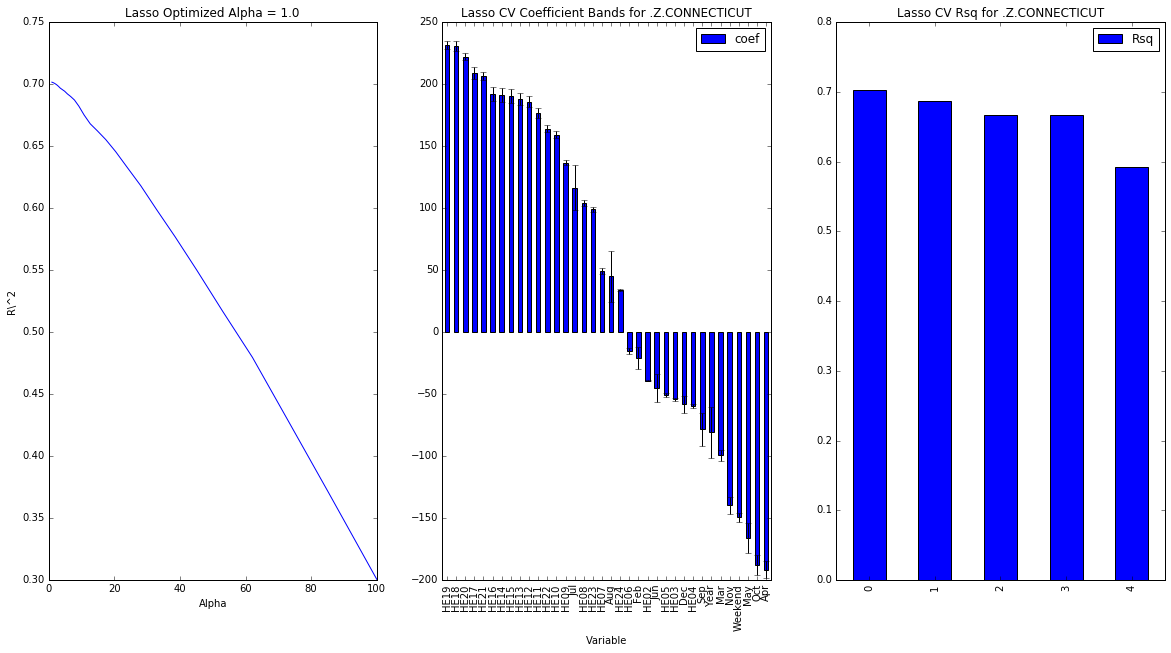

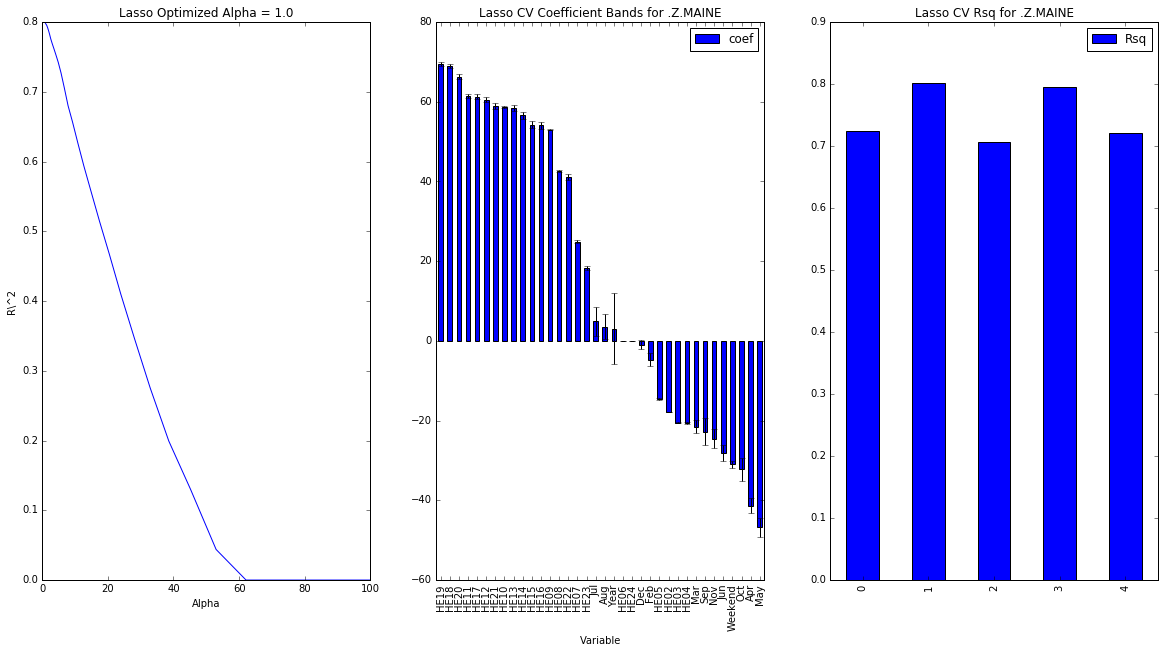

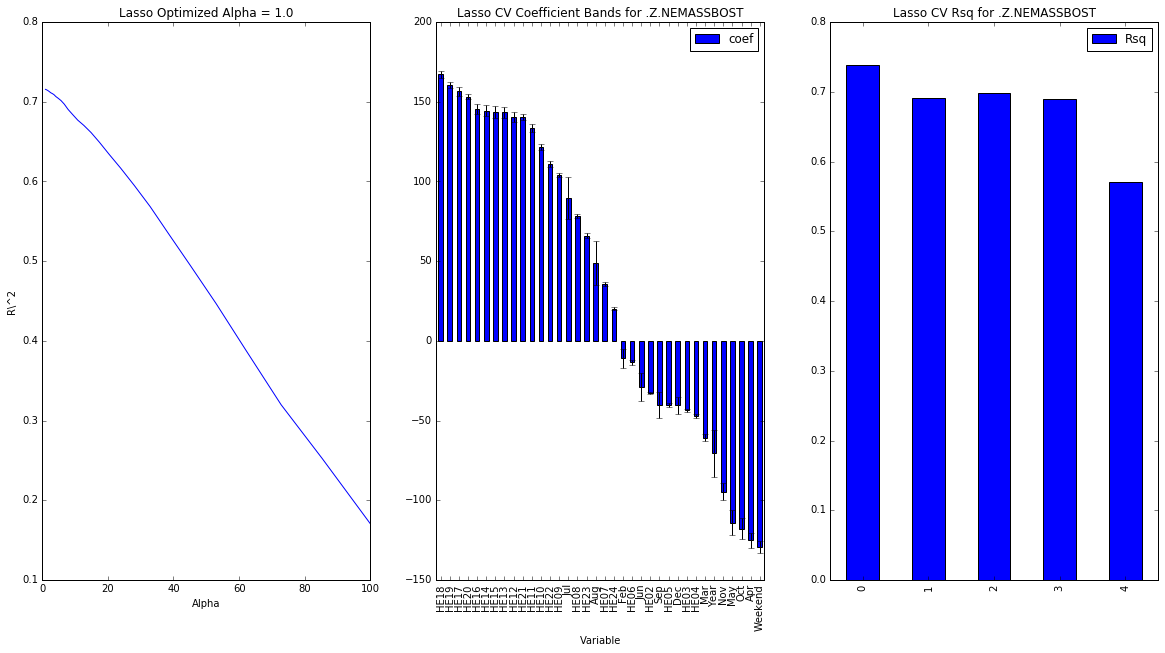

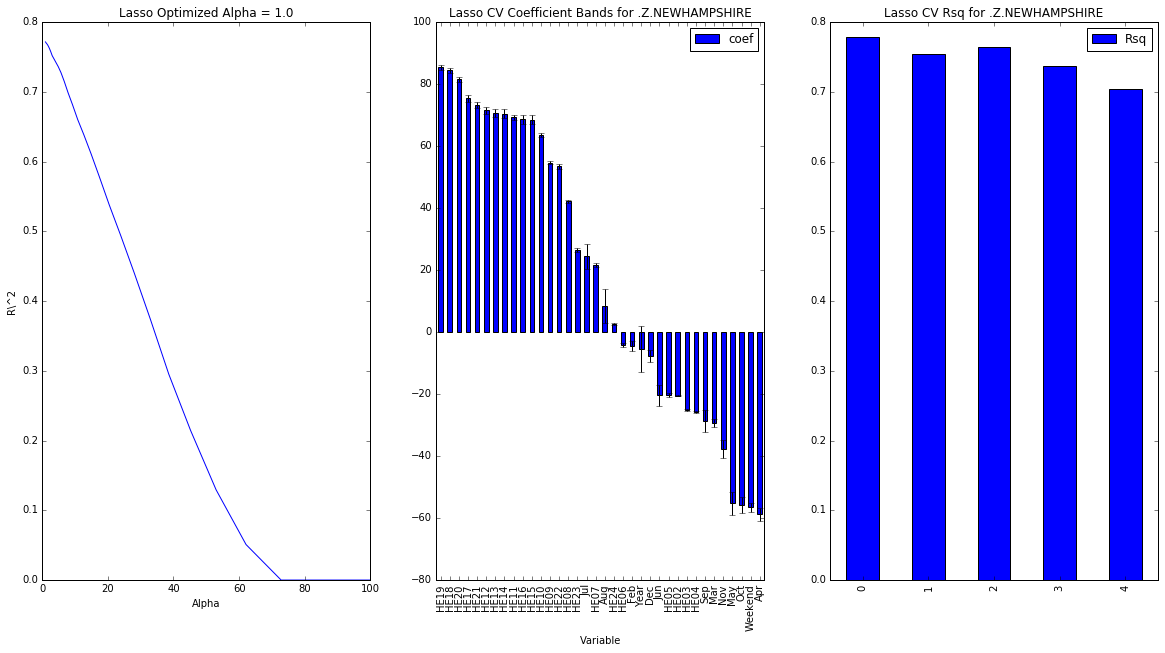

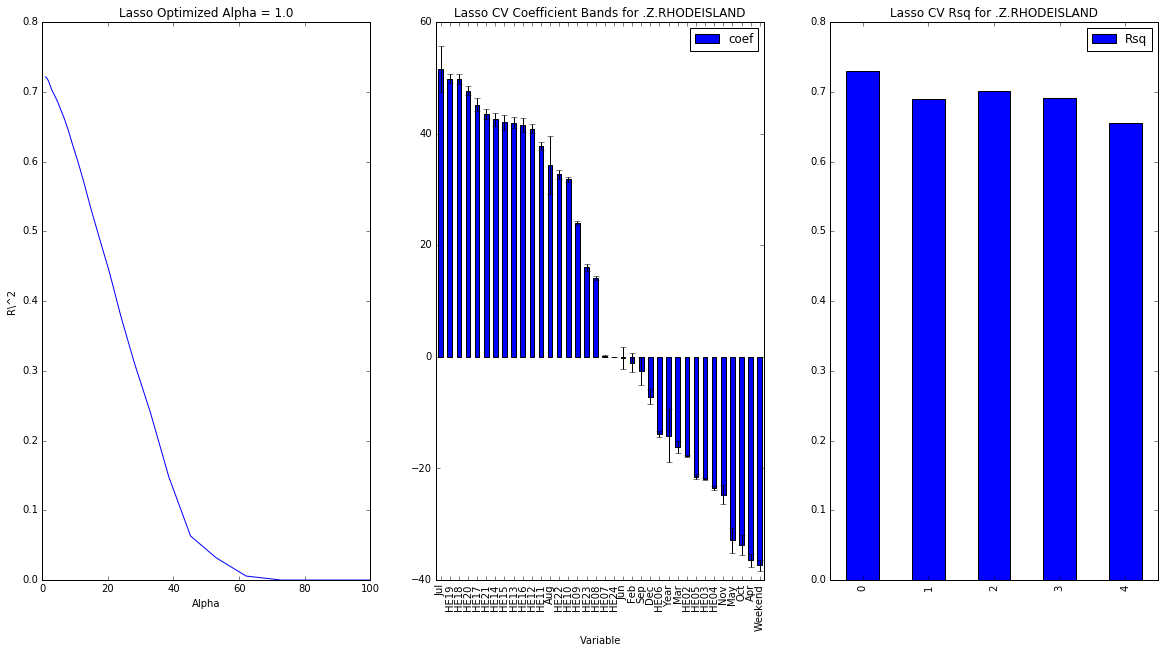

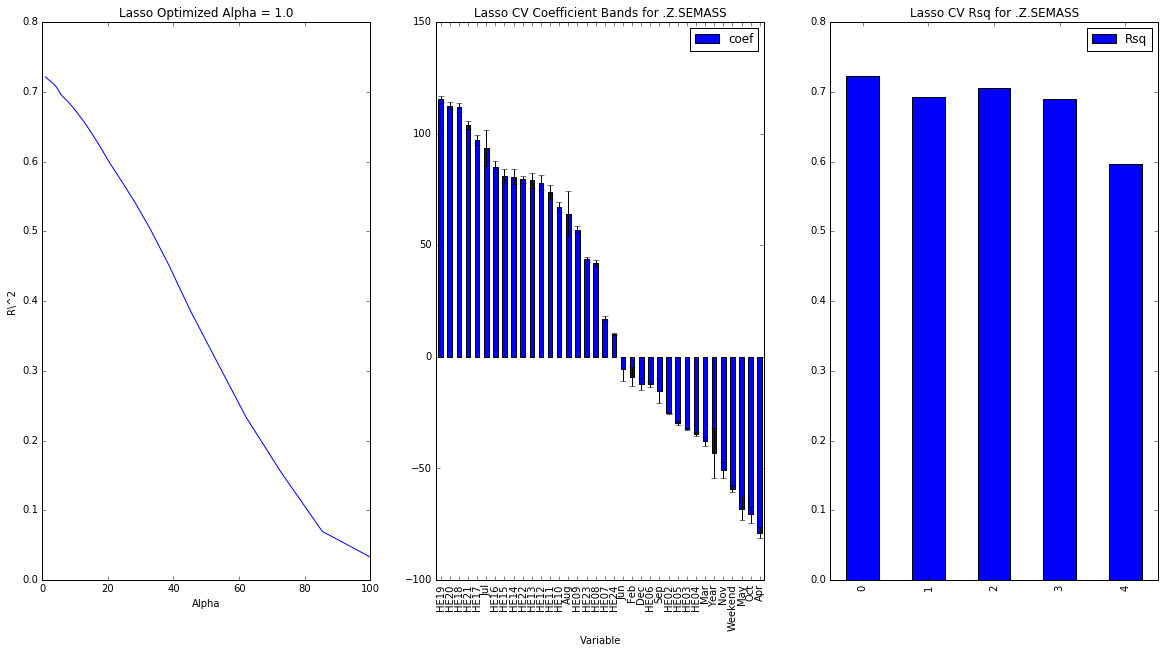

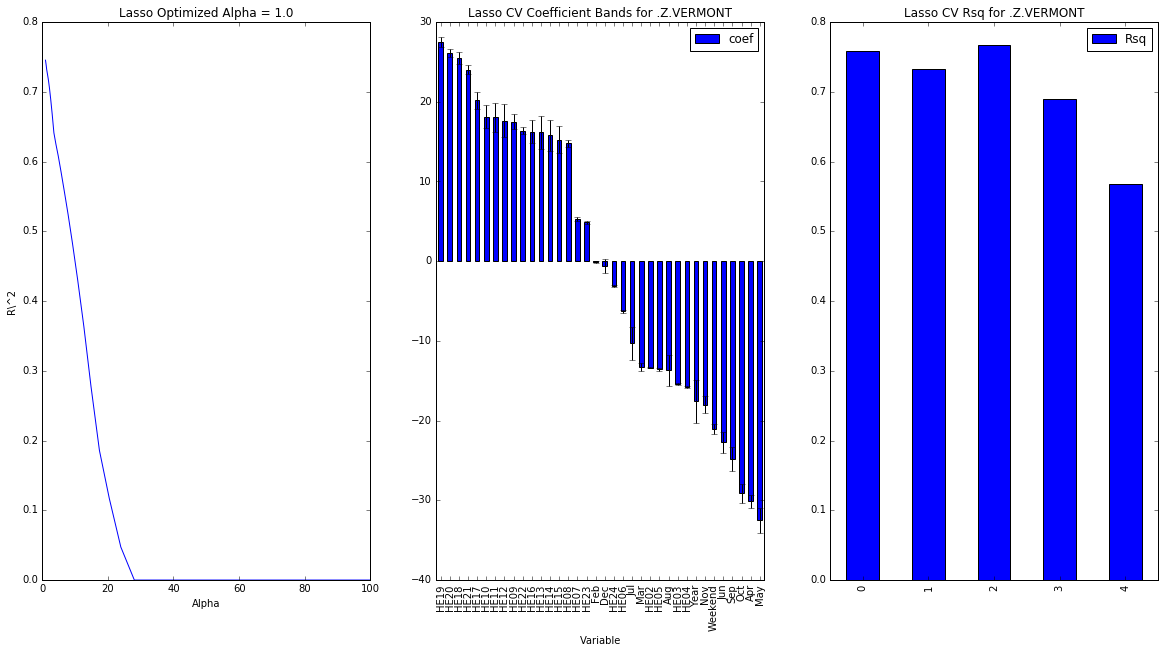

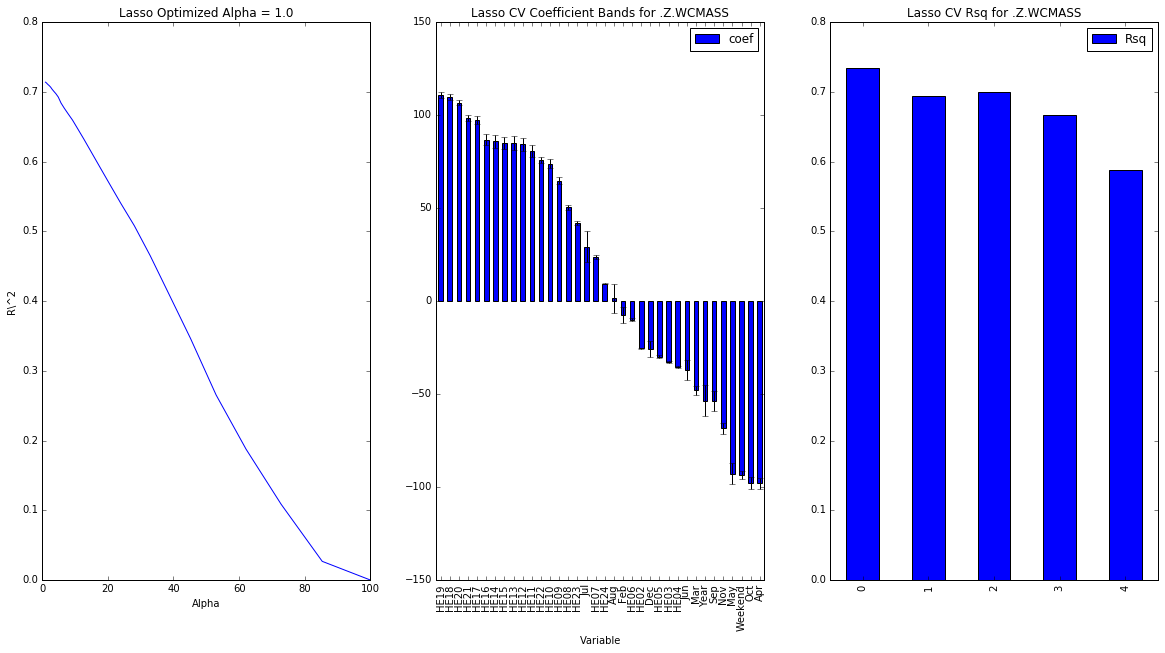

In [14]:
alphas = np.logspace(0,2,30)
dummy_cal_mos = ["Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
dummy_he = ["HE%.2d" % h for h in range(2,25)]
seasonal_variables = dummy_cal_mos + dummy_he + ["Weekend","Year"]

for lz in load_zones:
    df = pd.read_hdf(r".\Cleaned Data\regression_df.hdf",lz)

    fig,ax = plt.subplots(1,3,figsize=(20,10))
    scores = []
    scaler = StandardScaler()

    X = scaler.fit_transform(df[seasonal_variables])
    y = df[lz]

    for _alpha in alphas:
        regr = Lasso(alpha=_alpha,fit_intercept=True)
        regr.fit(X,y)
        rsq = regr.score(X,y)
        scores.append(rsq)

        alpha_best = alphas[np.argmax(scores)]    


    ax[0].plot(alphas,scores)
    ax[0].set_xlabel("Alpha")
    ax[0].set_ylabel("R\^2")
    ax[0].set_title("Lasso Optimized Alpha = {}".format(alpha_best))

    coeffs, scores =run_cv_coeffs(X,y.values,Lasso,alpha=alpha_best,fit_intercept=True)
    coeffs = np.array(coeffs)
    coeffs_avg,coeffs_std=get_coeffs(coeffs)

    dfCoeffs = pd.DataFrame({'type':seasonal_variables, 'coef':coeffs_avg, 'std':coeffs_std})
    dfCoeffs_sorted = dfCoeffs.sort_values(['coef'])[::-1]
    yerr_vals = dfCoeffs_sorted['std'].values

    dfCoeffs_sorted.plot(x='type',y='coef',kind='bar',yerr=yerr_vals,ax=ax[1])
    ax[1].set_title("Lasso CV Coefficient Bands for {}".format(lz))
    ax[1].set_xlabel("Variable")

    rsq_df = pd.DataFrame({'Fold':["CV%d"%d for d in range(5)], 'Rsq':scores})
    rsq_df.plot(ax=ax[2],kind="bar",title="Lasso CV Rsq for {}".format(lz))

    plt.show()

We pretty much already know that these seasonal variables have an impact on the regression, from looking at some of the earlier plots.  Even using regularization, the purely "seasonal parameters" model provides in general 60-70% Rsquared on a cross validated basis.

We see that the coefficient estimatios are quote robust for some of the large postive categoies (HE19,HE18 - these are high demand hours), weekend and April consistently negative (less demand in general, shoulder months in the Power Market, mild temps).  Next step is to model a residual using the weather factors.  

## Model Selection: Weather Variables

Thre is significant correlation among the temperature variables, as expected.  In order to attempt to resolve this, we will PCA transform them to see if we can remove redundancies.

We will first run a regression on the seasonal parameters and then regress the residual on the weather variables to see if our estimation is significant/robust.  

We also introduce squared terms of Temperature to help us handle the non-linear relationship between temperature and load - as can be seen from the earlier graphs (correlation flips in the winter, colder temps -> higher load).

In [15]:
df = pd.read_hdf(r".\Cleaned Data\regression_df.hdf",'.Z.NEMASSBOST')
weather_vars = ['Rain', 'Snow', 'Clear', 'Few Clouds', 'Missing',
       'Overcast', 'Scattered', 'Vertical Visibility Ltd.',
       'Temperature (Dry Bulb) - Fahrenheit','Heat Index Temperature - Fahrenheit','Wind Chill Temperature - Fahrenheit']

for t in temp_cols:
    df[t + " Sq"] = df[t]**2.0
    weather_vars.append(t + " Sq")

corr_df = df[weather_vars].corr()
corr_df.name = "Weather Variable Corr for {}".format(lz)
corr_df


,Rain,Snow,Clear,Few Clouds,Missing,Overcast,Scattered,Vertical Visibility Ltd.,Temperature (Dry Bulb) - Fahrenheit,Heat Index Temperature - Fahrenheit,Wind Chill Temperature - Fahrenheit,Temperature (Dry Bulb) - Fahrenheit Sq,Heat Index Temperature - Fahrenheit Sq,Wind Chill Temperature - Fahrenheit Sq
Rain,1.000000,0.158923,-0.123949,-0.163669,-0.078612,0.470619,-0.119541,-0.000595,-0.001925,-0.002843,-0.001454,-0.026315,-0.027418,-0.029624
Snow,0.158923,1.000000,-0.051911,-0.067872,-0.030820,0.180837,-0.053706,0.214243,-0.194601,-0.193534,-0.206456,-0.172342,-0.170179,-0.174949
Clear,-0.123949,-0.051911,1.000000,-0.155225,-0.072535,-0.210944,-0.127519,-0.029300,-0.141213,-0.141021,-0.133797,-0.125379,-0.124791,-0.115109
Few Clouds,-0.163669,-0.067872,-0.155225,1.000000,-0.096144,-0.279605,-0.169026,-0.038837,0.032322,0.032222,0.026662,0.048375,0.047817,0.049399
Missing,-0.078612,-0.030820,-0.072535,-0.096144,1.000000,-0.130655,-0.078983,-0.018148,-0.151277,-0.150920,-0.152839,-0.156803,-0.155454,-0.162339
Overcast,0.470619,0.180837,-0.210944,-0.279605,-0.130655,1.000000,-0.229698,-0.052778,-0.077868,-0.079574,-0.067937,-0.113043,-0.114917,-0.113050
Scattered,-0.119541,-0.053706,-0.127519,-0.169026,-0.078983,-0.229698,1.000000,-0.031905,0.121244,0.121893,0.114000,0.136056,0.136382,0.133241
Vertical Visibility Ltd.,-0.000595,0.214243,-0.029300,-0.038837,-0.018148,-0.052778,-0.031905,1.000000,-0.060830,-0.060689,-0.060376,-0.059216,-0.058754,-0.056827
Temperature (Dry Bulb) - Fahrenheit,-0.001925,-0.194601,-0.141213,0.032322,-0.151277,-0.077868,0.121244,-0.060830,1.000000,0.999583,0.993084,0.978110,0.973760,0.973090
Heat Index Temperature - Fahrenheit,-0.002843,-0.193534,-0.141021,0.032222,-0.150920,-0.079574,0.121893,-0.060689,0.999583,1.000000,0.992062,0.979991,0.977039,0.974672


In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
trans_data = pca.fit_transform(df[weather_vars[-6:]])
pca_df=pd.DataFrame(index=weather_vars[-6:],columns=["Comp{} {:.1%}".format(i+1,pca.explained_variance_ratio_[i]) for i in range(3)],data=pca.components_.T)
weather_vars_pca = weather_vars.copy()
weather_vars_pca.append("Temp_PCA1")
weather_vars_pca.append("Temp_PCA2")
pca_df

,Comp1 99.8%,Comp2 0.2%,Comp3 0.0%
Temperature (Dry Bulb) - Fahrenheit,0.005376,0.001928,-0.031403
Heat Index Temperature - Fahrenheit,0.005440,0.003830,-0.023744
Wind Chill Temperature - Fahrenheit,0.006267,-0.009745,-0.027667
Temperature (Dry Bulb) - Fahrenheit Sq,0.559810,0.241518,-0.791471
Heat Index Temperature - Fahrenheit Sq,0.570924,0.580789,0.579769
Wind Chill Temperature - Fahrenheit Sq,0.600467,-0.777329,0.187421


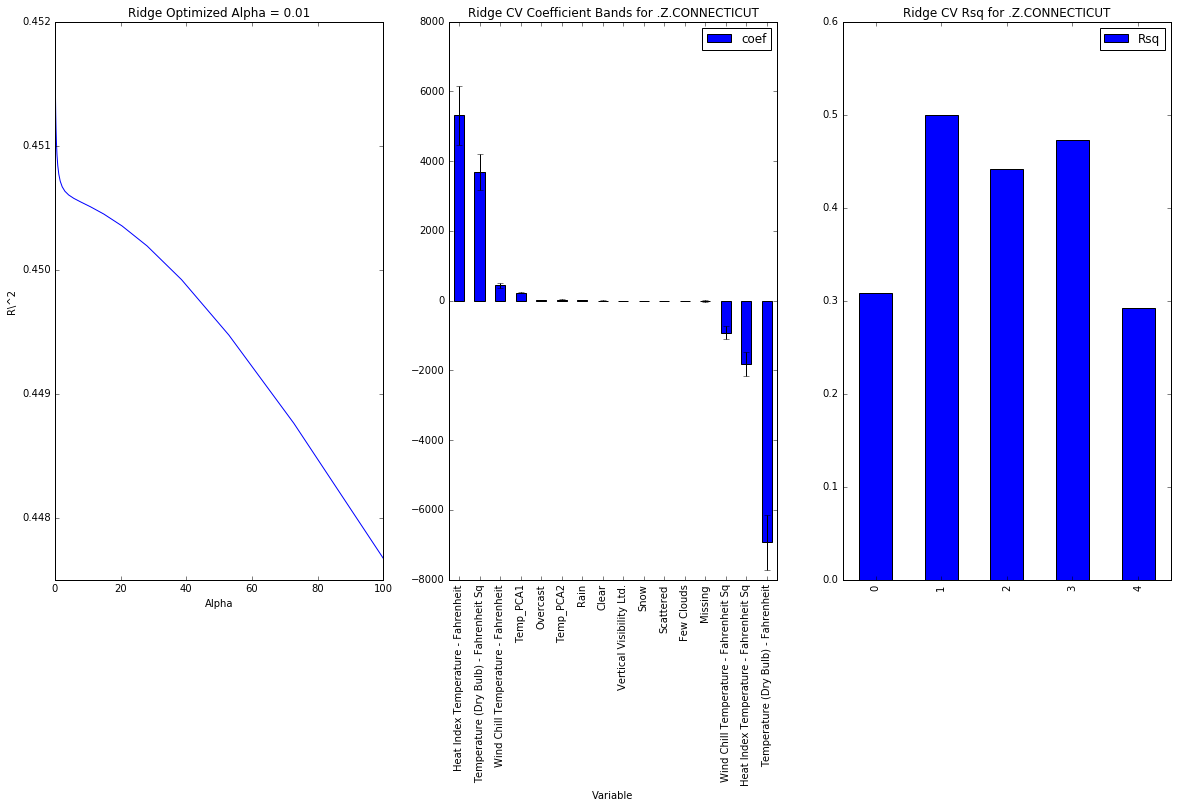

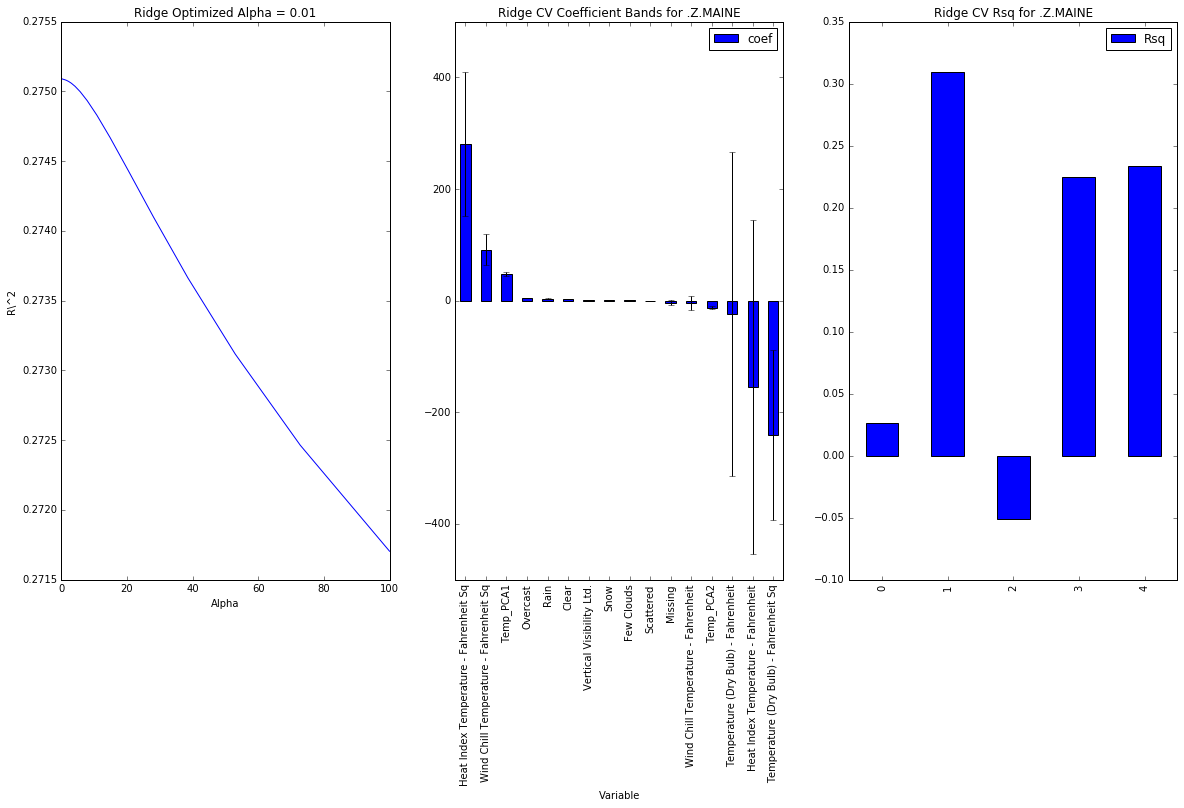

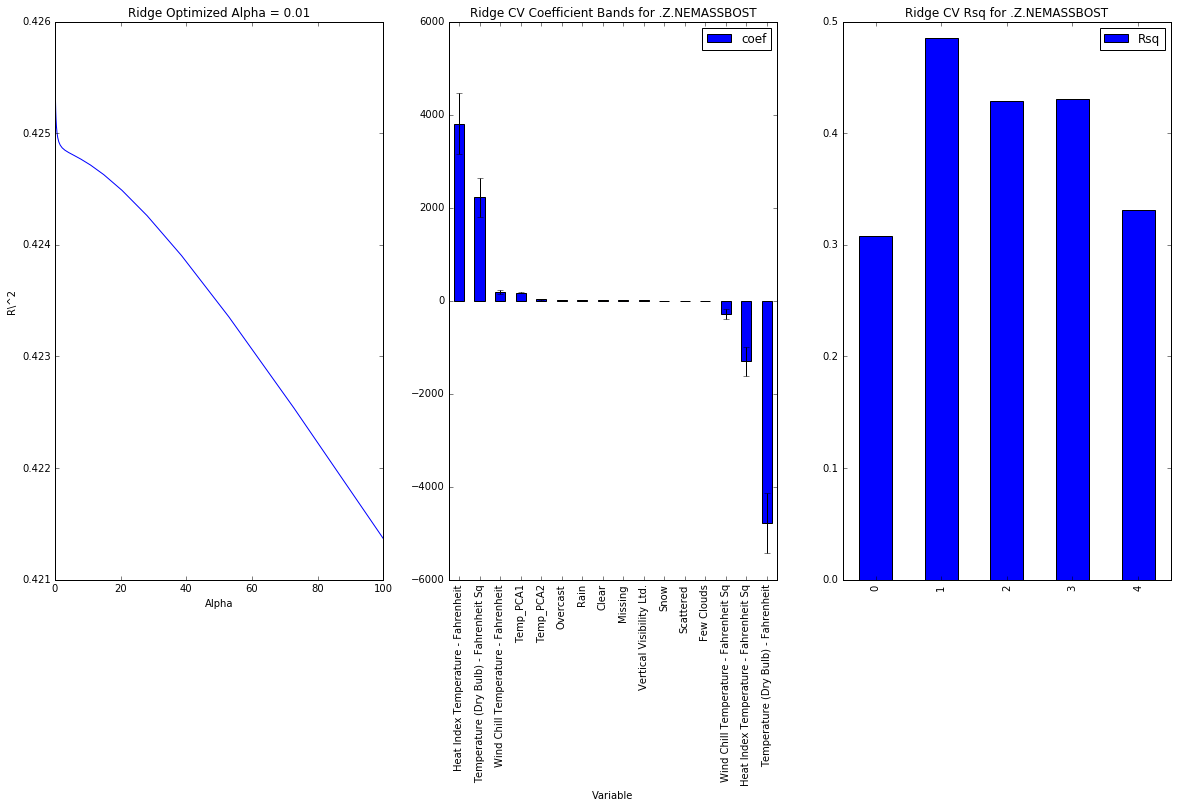

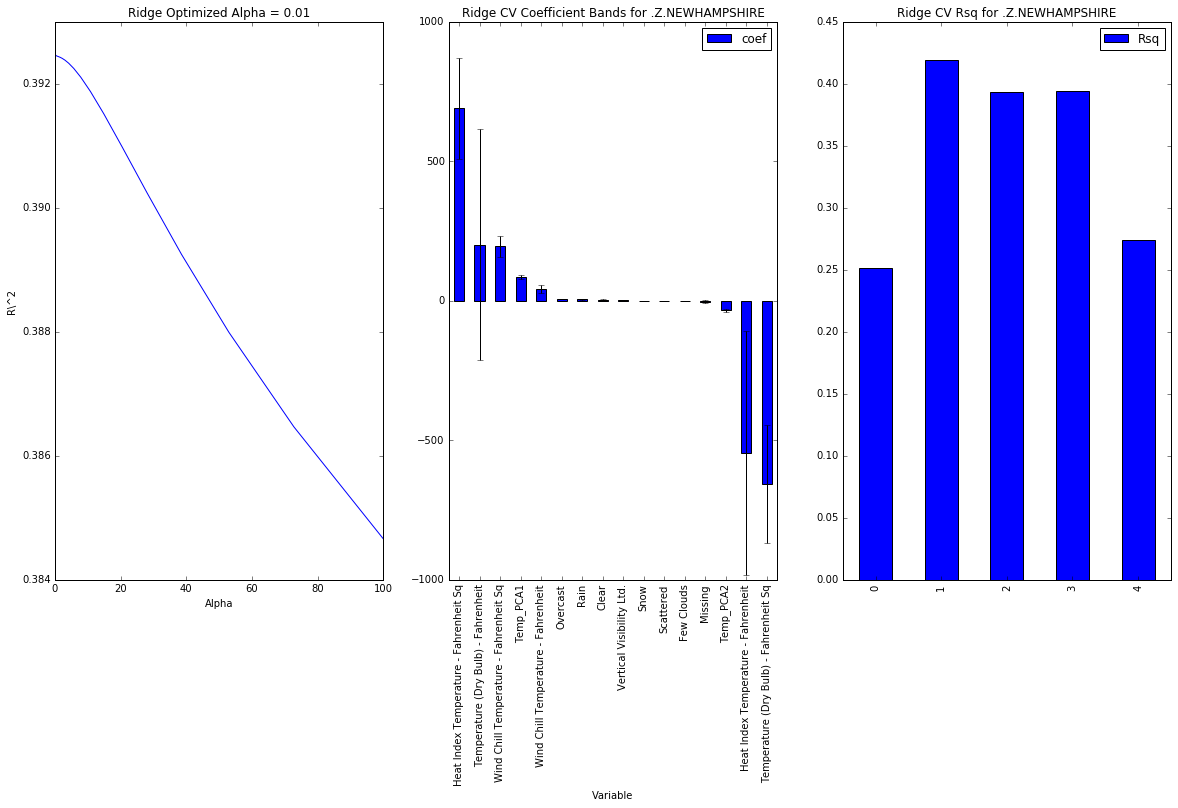

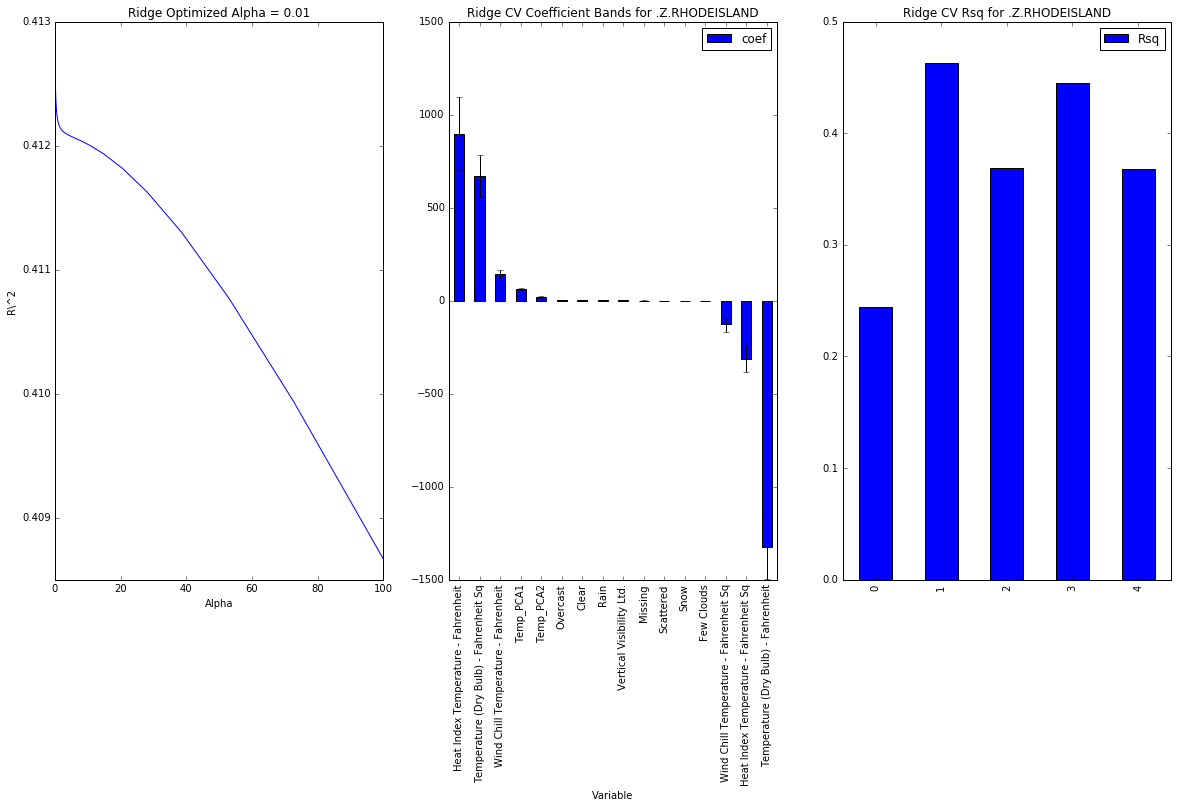

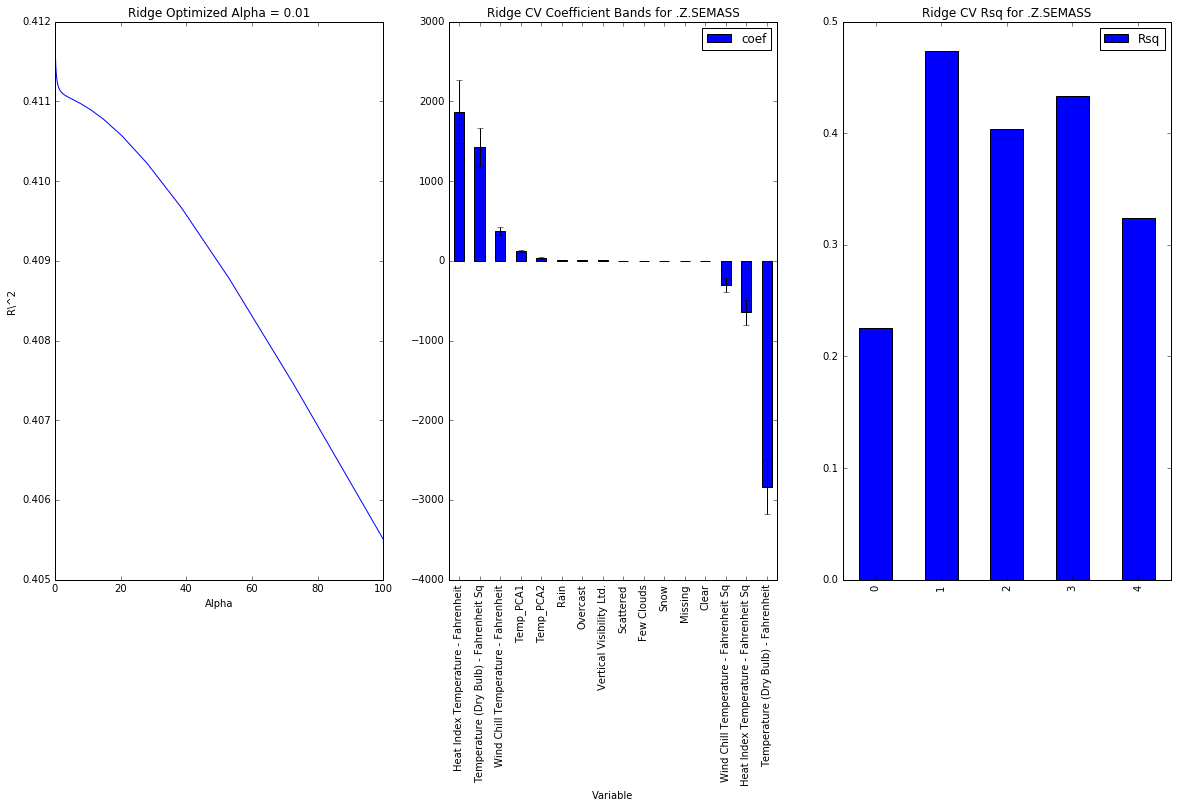

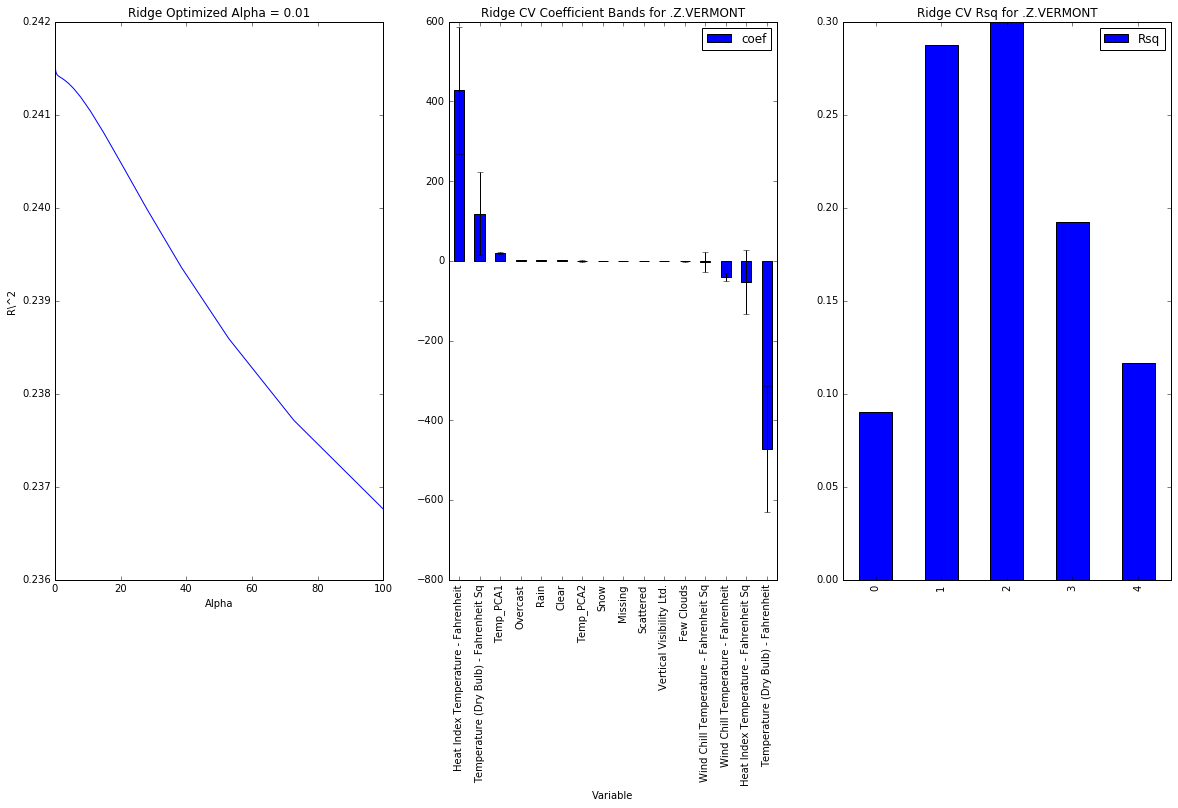

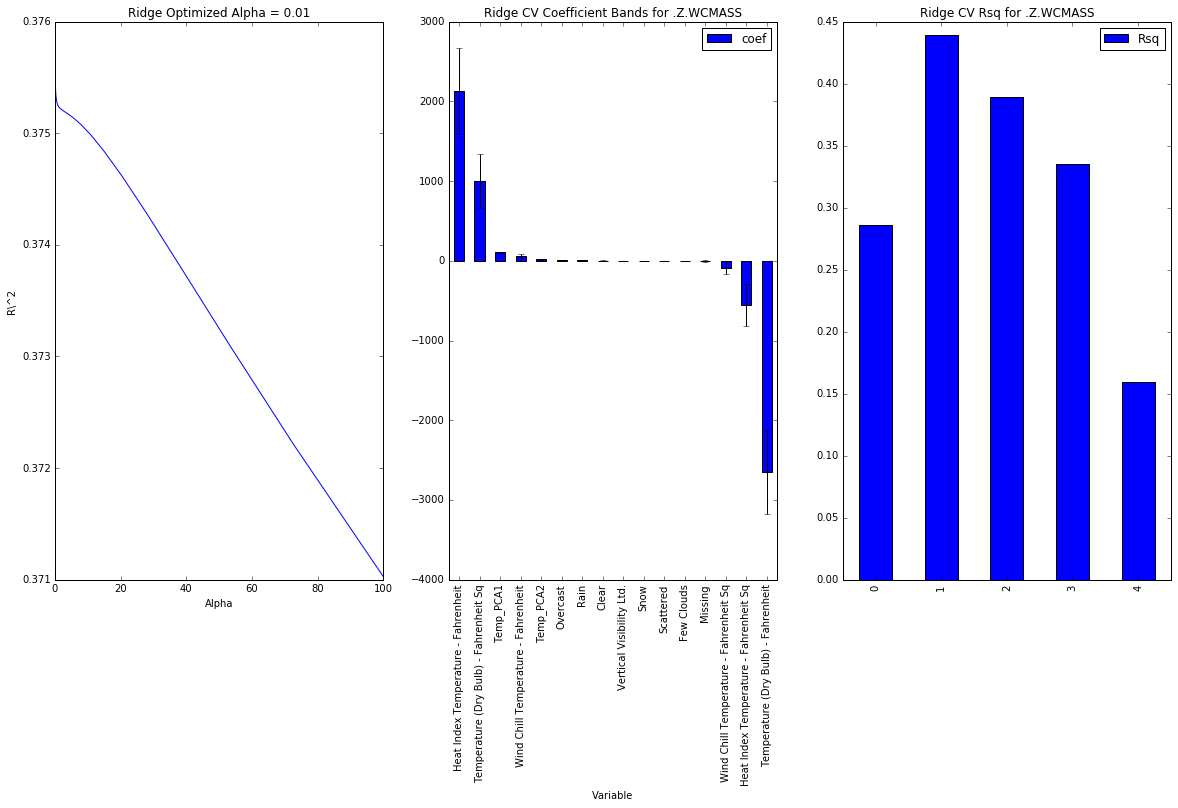

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
for lz in load_zones:
    alphas = np.logspace(-2,2,30)
    df = pd.read_hdf(r".\Cleaned Data\regression_df.hdf",lz)
    X = df[seasonal_variables]
    y = df[lz]

    for t in temp_cols:
        df[t + " Sq"] = df[t]**2.0

    trans_data = PCA(n_components=2).fit_transform(df[weather_vars[-6:]])
    df["Temp_PCA1"] = trans_data[:,0]
    df["Temp_PCA2"] = trans_data[:,1]
    fig,ax = plt.subplots(1,3,figsize=(20,10))


    regr = GridSearchCV(LinearRegression(), {'fit_intercept':[True]})
    regr.fit(X,y)
    y_s = pd.Series(index=df.index,data=regr.predict(X))
    y_s.name = "Seasonal {}".format(lz)
    y_res = y - y_s

    scores = []
    scaler = StandardScaler()

    #X = scaler.fit_transform(df[weather_vars])
    X = scaler.fit_transform(df[weather_vars_pca])
    #y = df[lz]

    for _alpha in alphas:
        regr = Ridge(alpha=_alpha)
        regr.fit(X,y_res)
        rsq = regr.score(X,y_res)
        scores.append(rsq)

    alpha_best = alphas[np.argmax(scores)]    
    ax[0].plot(alphas,scores)
    ax[0].set_xlabel("Alpha")
    ax[0].set_ylabel("R\^2")
    ax[0].set_title("Ridge Optimized Alpha = {}".format(alpha_best))

    coeffs, scores = run_cv_coeffs(X,y_res,Ridge,alpha=alpha_best,fit_intercept=False)
    #coeffs, scores = run_cv_coeffs(X,y_res,LinearRegression,fit_intercept=False)
    coeffs = np.array(coeffs)
    coeffs_avg,coeffs_std=get_coeffs(coeffs)

    dfCoeffs = pd.DataFrame({'type':weather_vars_pca, 'coef':coeffs_avg, 'std':coeffs_std})
    #dfCoeffs = pd.DataFrame({'type':weather_vars, 'coef':coeffs_avg, 'std':coeffs_std})
    dfCoeffs_sorted = dfCoeffs.sort_values(['coef'])[::-1]
    yerr_vals = dfCoeffs_sorted['std'].values

    dfCoeffs_sorted.plot(x='type',y='coef',kind='bar',yerr=yerr_vals,ax=ax[1])
    ax[1].set_title("Ridge CV Coefficient Bands for {}".format(lz))
    ax[1].set_xlabel("Variable")

    rsq_df = pd.DataFrame({'Fold':["CV%d"%d for d in range(5)], 'Rsq':scores})
    rsq_df.plot(ax=ax[2],kind="bar",title="Ridge CV Rsq for {}".format(lz))

    plt.show()

### Removing Interactions

So the PCA was not succesful in helping us remove the effect of correlated features.  Not shown in this notebook, but when running on the PCA Factors alone (other temperature metrics) - the regression results become very unstable and the regression fails.  A far more succefull idea was to take the cross product of the linear terms of the temperature variables.

In addition, the qualitiative variables describing the weather (Rain/Snow, etc) turned out to not be very useful, as can be seen by the ridge regression results.


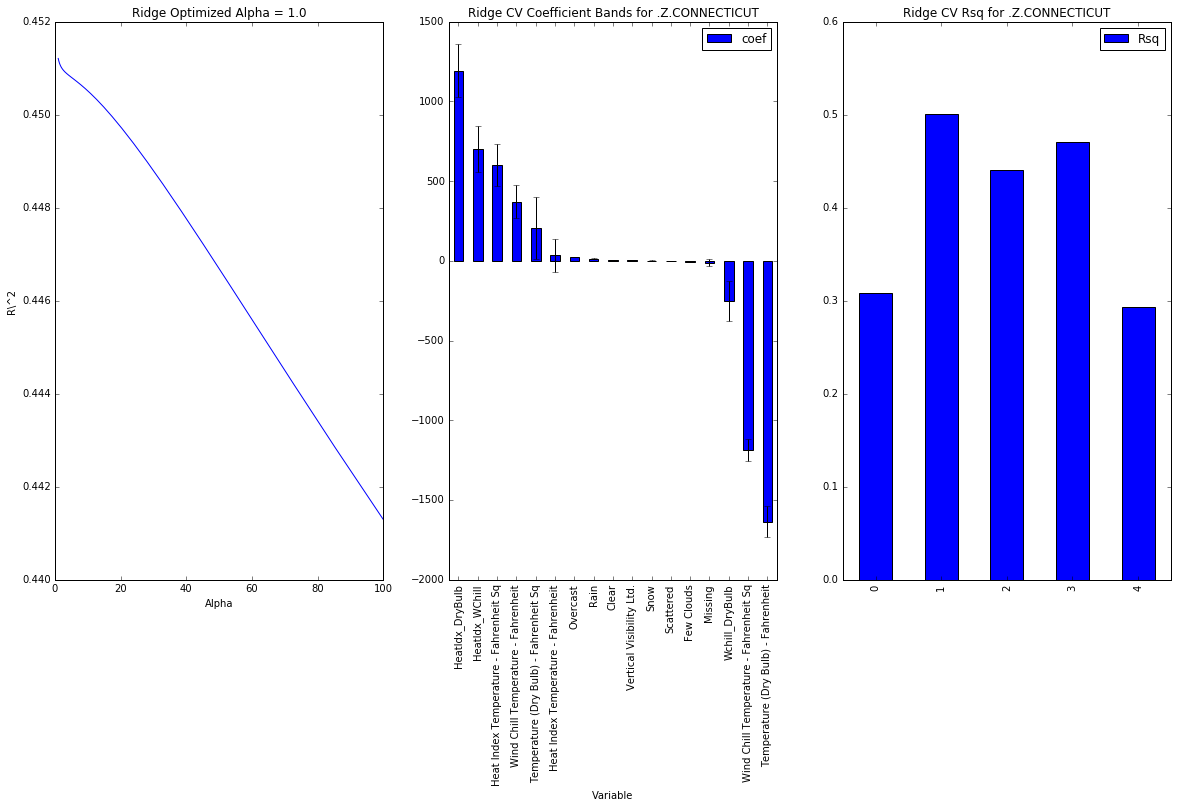

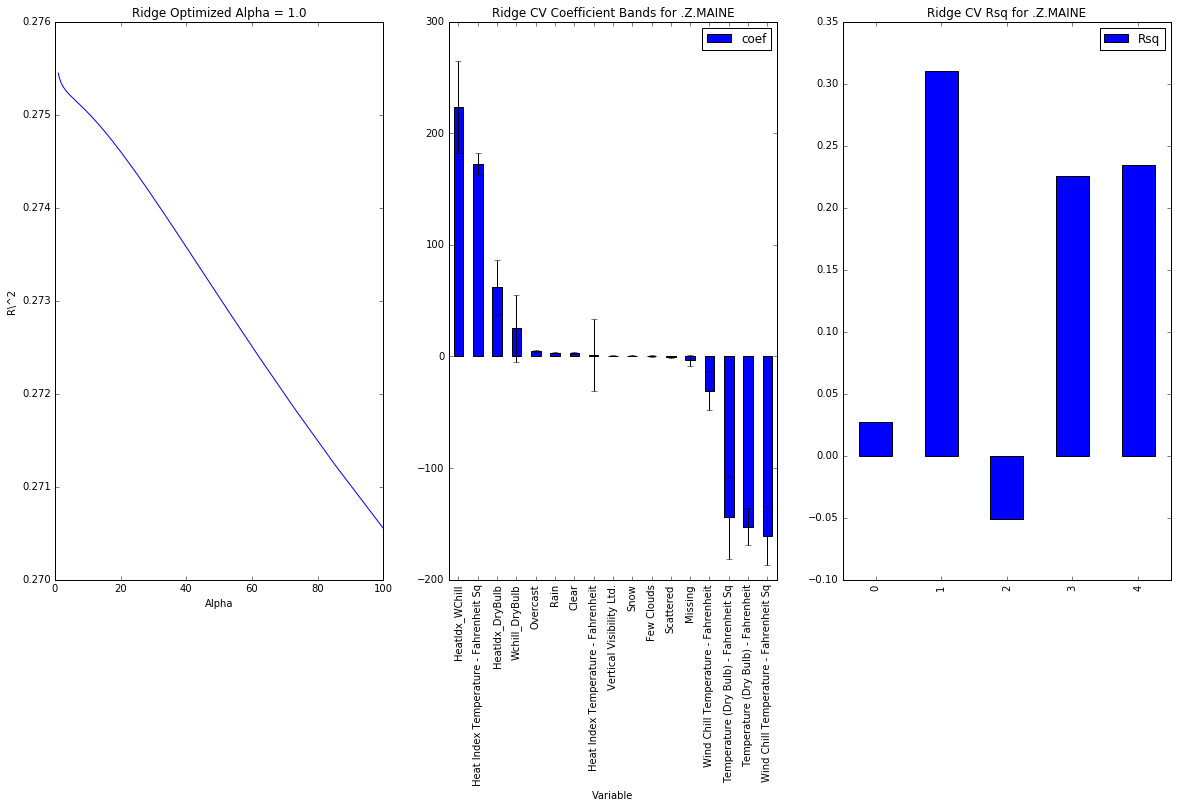

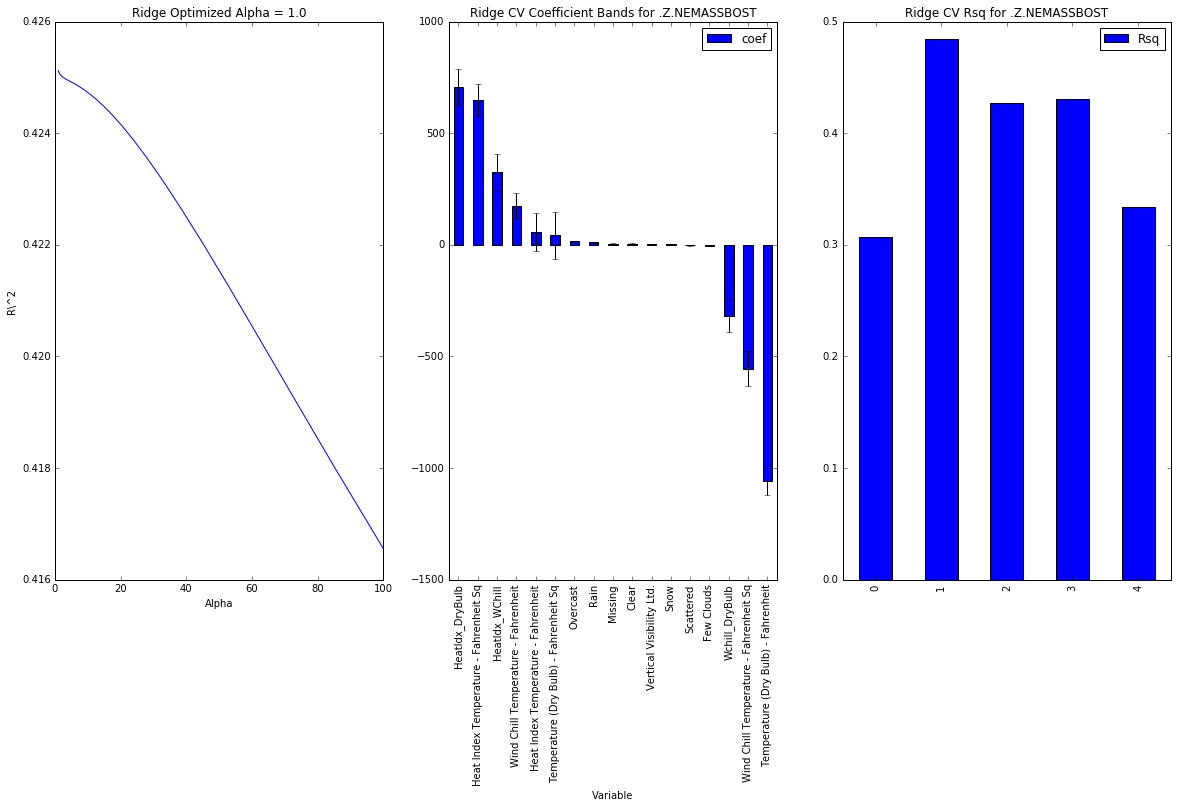

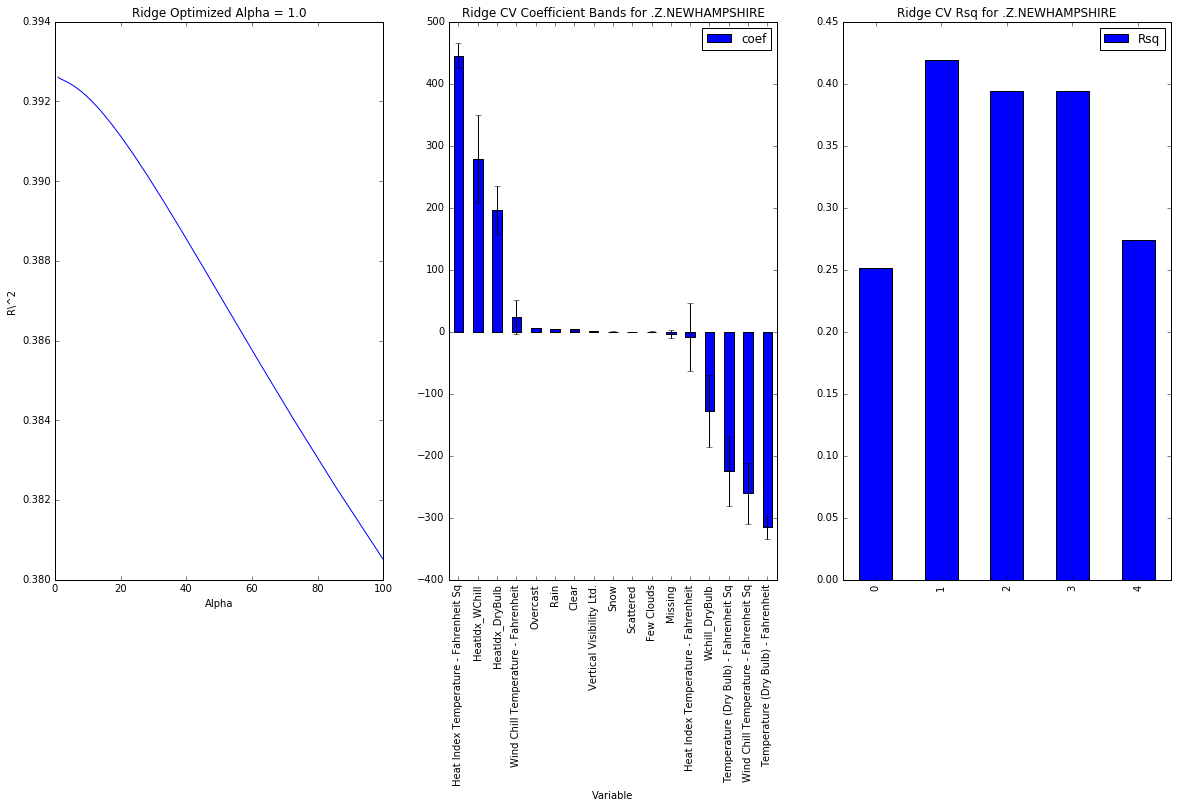

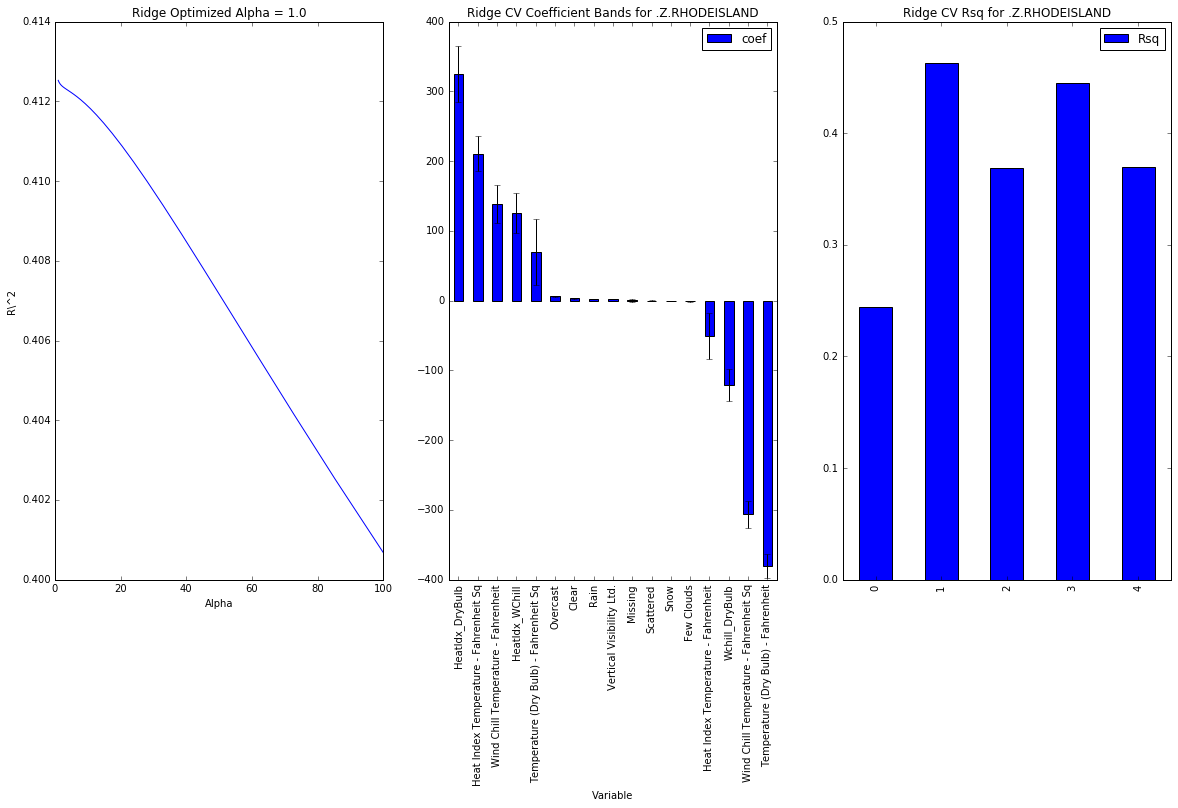

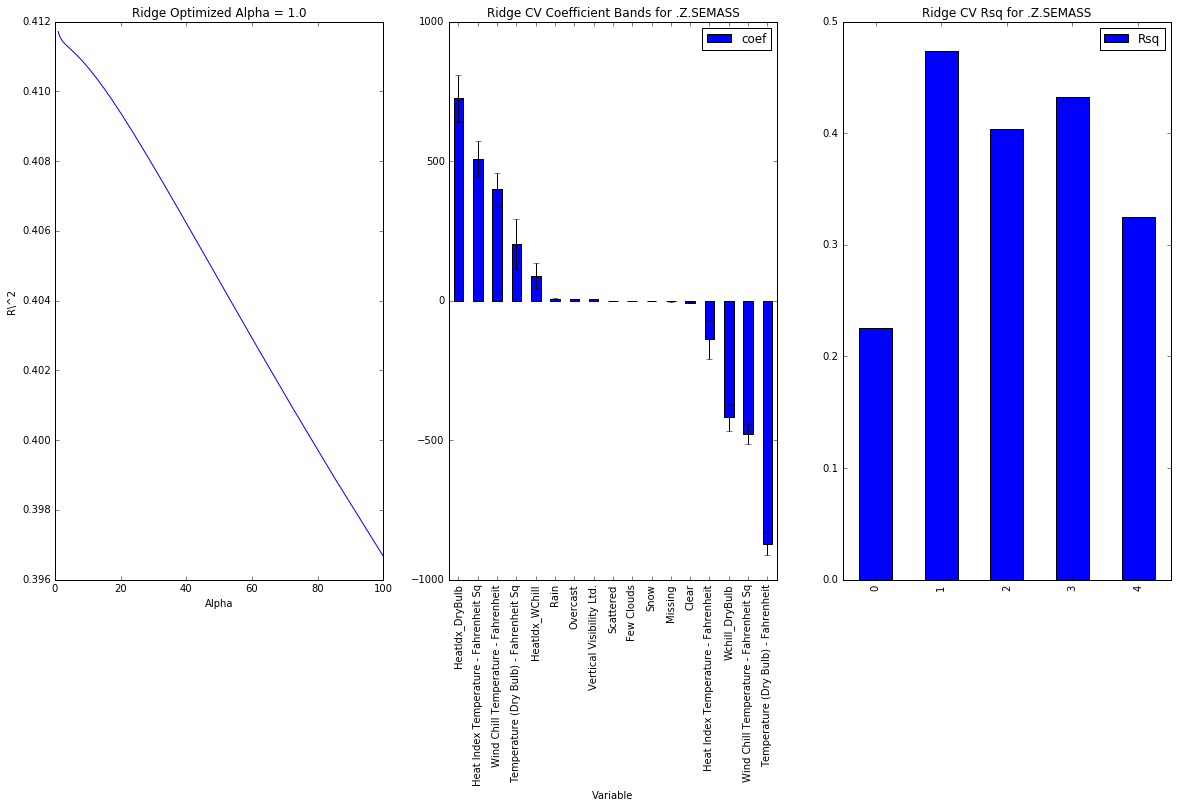

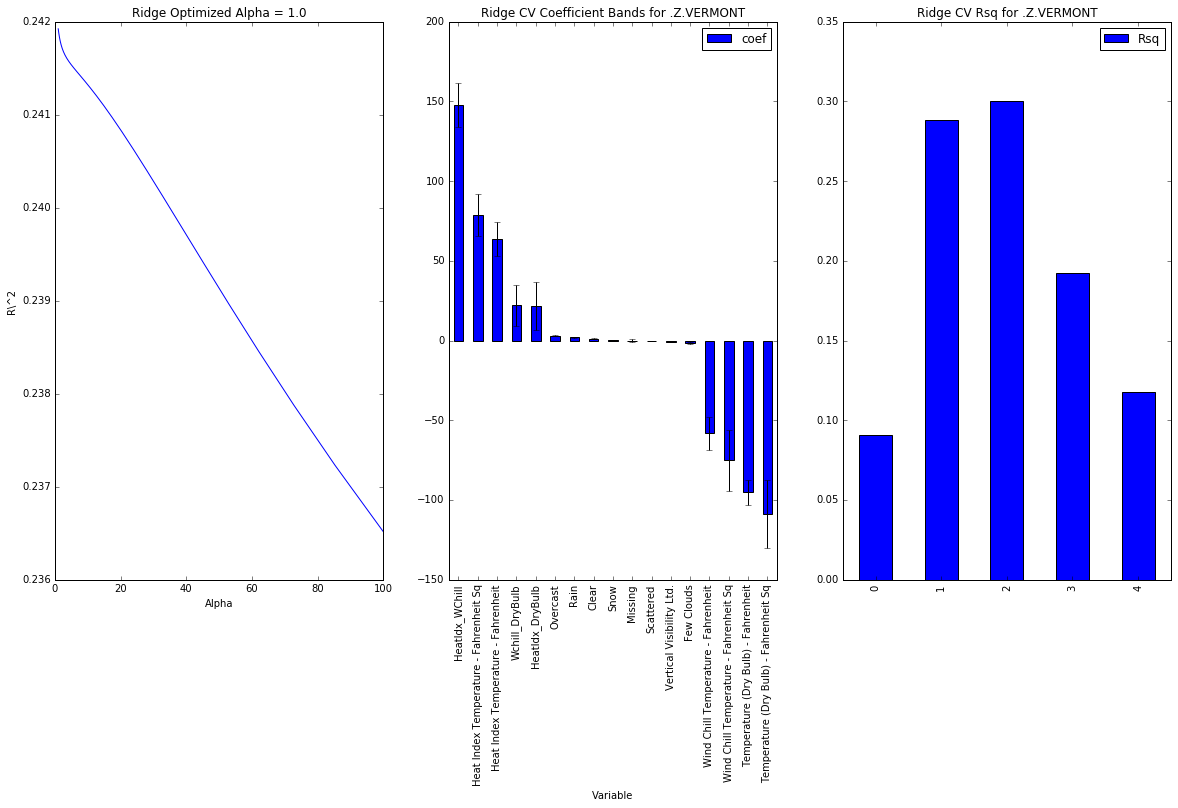

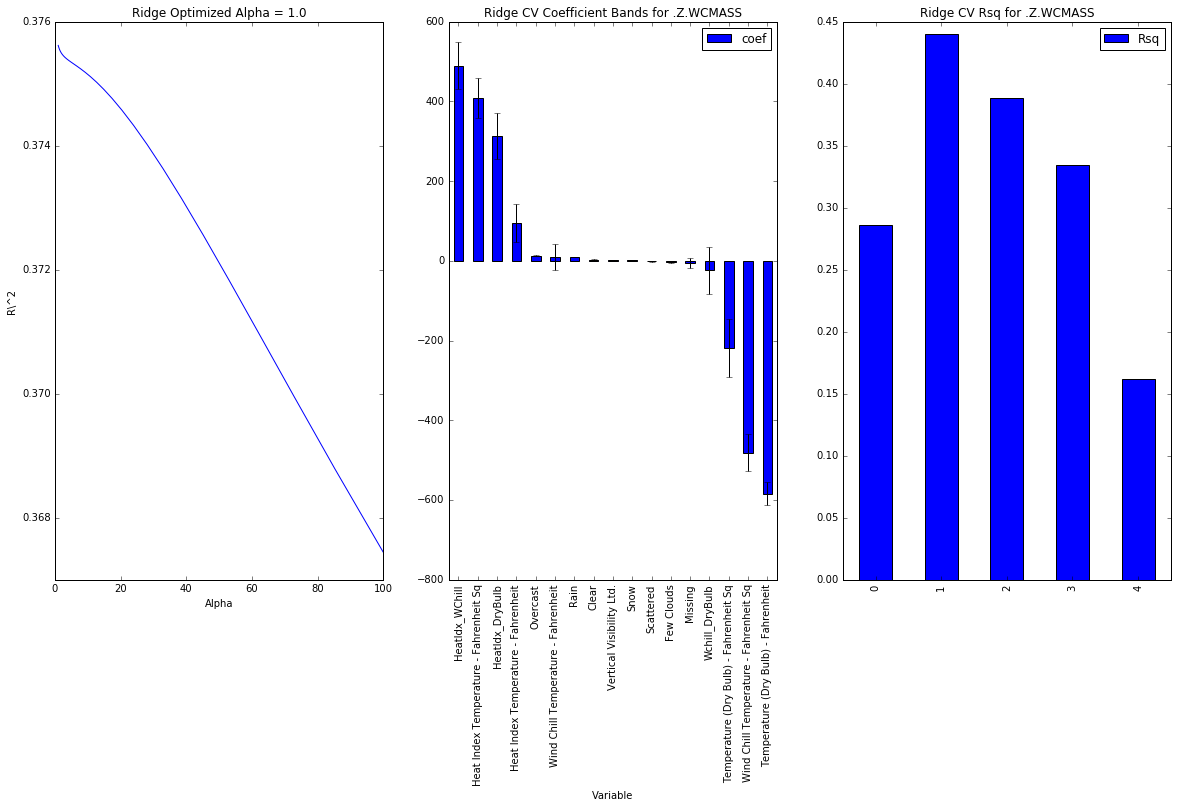

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
for lz in load_zones:
    alphas = np.logspace(0,2,30)
    df = pd.read_hdf(r".\Cleaned Data\regression_df.hdf",lz)
        
    
    X = df[seasonal_variables]
    y = df[lz]

    for t in temp_cols:
        df[t + " Sq"] = df[t]**2.0
    df["Wchill_DryBulb"] = df[temp_cols[0]]*df[temp_cols[2]]
    df["HeatIdx_DryBulb"] = df[temp_cols[0]]*df[temp_cols[1]]
    df["HeatIdx_WChill"] = df[temp_cols[1]]*df[temp_cols[2]]
    
    
    fig,ax = plt.subplots(1,3,figsize=(20,10))


    regr = GridSearchCV(LinearRegression(), {'fit_intercept':[True]},cv=5)
    regr.fit(X,y)
    y_s = pd.Series(index=df.index,data=regr.predict(X))
    y_s.name = "Seasonal {}".format(lz)
    y_res = y - y_s
    
    scores = []
    scaler = StandardScaler()

    X = scaler.fit_transform(df[weather_vars + ["Wchill_DryBulb","HeatIdx_DryBulb","HeatIdx_WChill"]])
    
    #y = df[lz]

    for _alpha in alphas:
        regr = Ridge(alpha=_alpha)
        regr.fit(X,y_res)
        rsq = regr.score(X,y_res)
        scores.append(rsq)

    alpha_best = alphas[np.argmax(scores)]    
    ax[0].plot(alphas,scores)
    ax[0].set_xlabel("Alpha")
    ax[0].set_ylabel("R\^2")
    ax[0].set_title("Ridge Optimized Alpha = {}".format(alpha_best))

    coeffs, scores = run_cv_coeffs(X,y_res,Ridge,alpha=alpha_best,fit_intercept=False)
    #coeffs, scores = run_cv_coeffs(X,y_res,LinearRegression,fit_intercept=False)
    coeffs = np.array(coeffs)
    coeffs_avg,coeffs_std=get_coeffs(coeffs)
    
    dfCoeffs = pd.DataFrame({'type':weather_vars + ["Wchill_DryBulb","HeatIdx_DryBulb","HeatIdx_WChill"], 'coef':coeffs_avg, 'std':coeffs_std})
    dfCoeffs_sorted = dfCoeffs.sort_values(['coef'])[::-1]
    yerr_vals = dfCoeffs_sorted['std'].values

    dfCoeffs_sorted.plot(x='type',y='coef',kind='bar',yerr=yerr_vals,ax=ax[1])
    ax[1].set_title("Ridge CV Coefficient Bands for {}".format(lz))
    ax[1].set_xlabel("Variable")

    rsq_df = pd.DataFrame({'Fold':["CV%d"%d for d in range(5)], 'Rsq':scores})
    rsq_df.plot(ax=ax[2],kind="bar",title="Ridge CV Rsq for {}".format(lz))

    plt.show()

## Final "Linear" Model

The five fold cross validated R squareds all range between ~85-90%, very robust predictive power.  You can also see the CV coefficient ranges are consistent, robust, with the same variables ending up as the largest/smallest respectively.

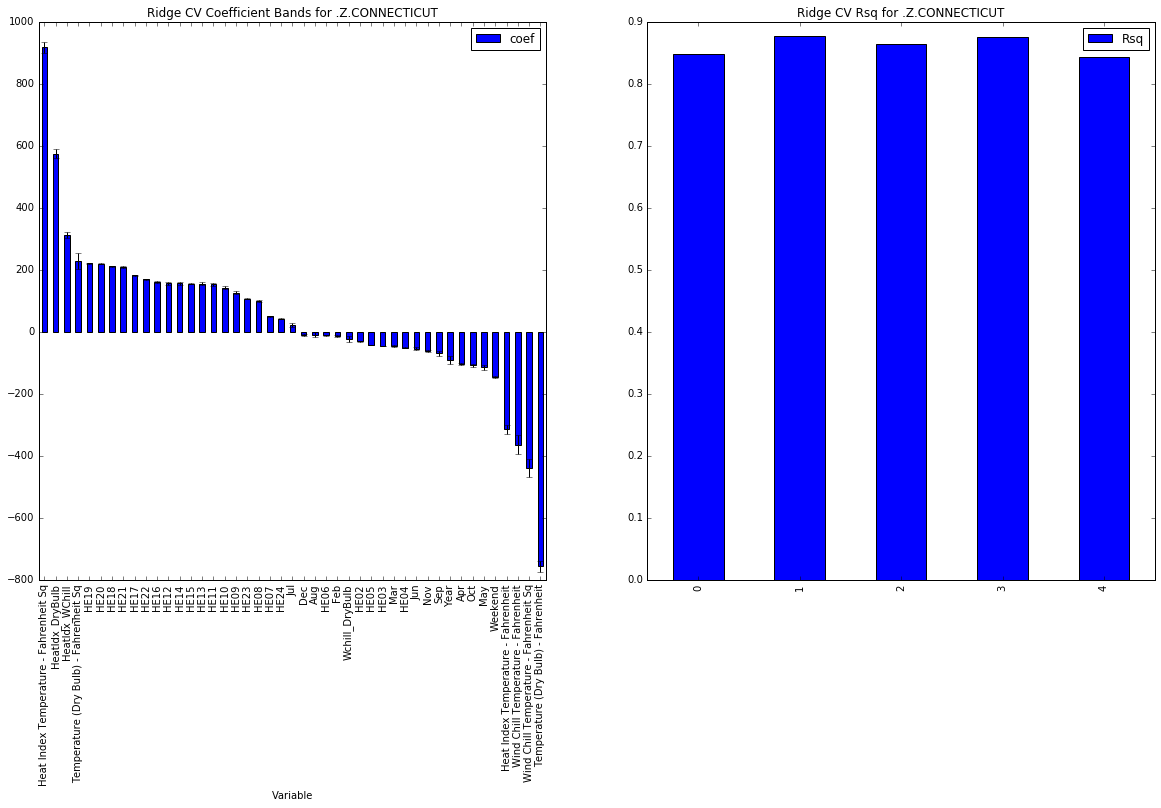

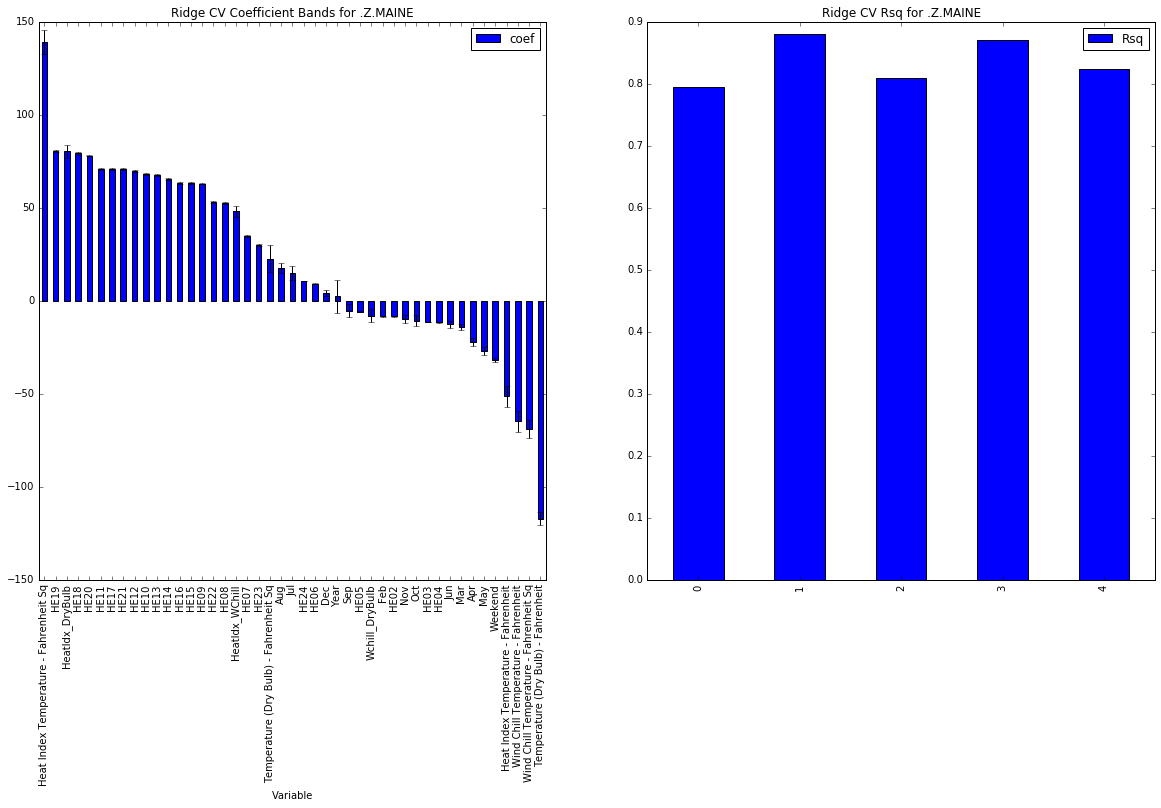

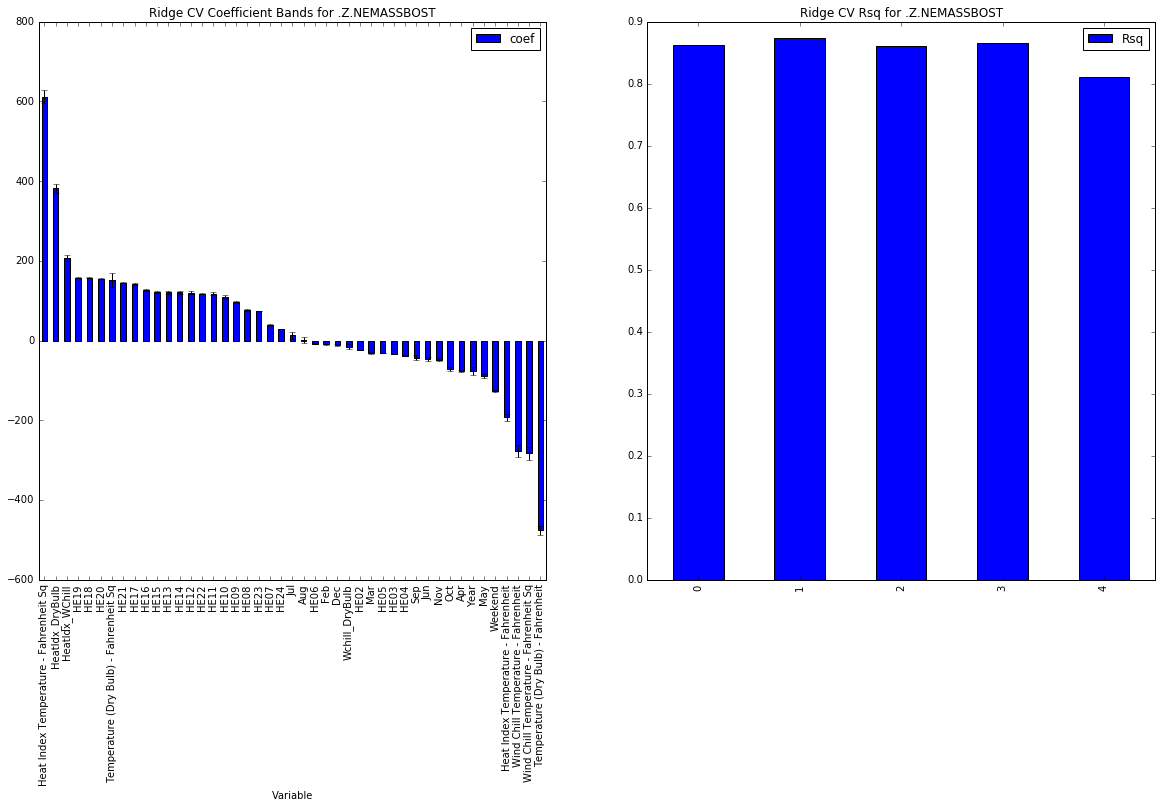

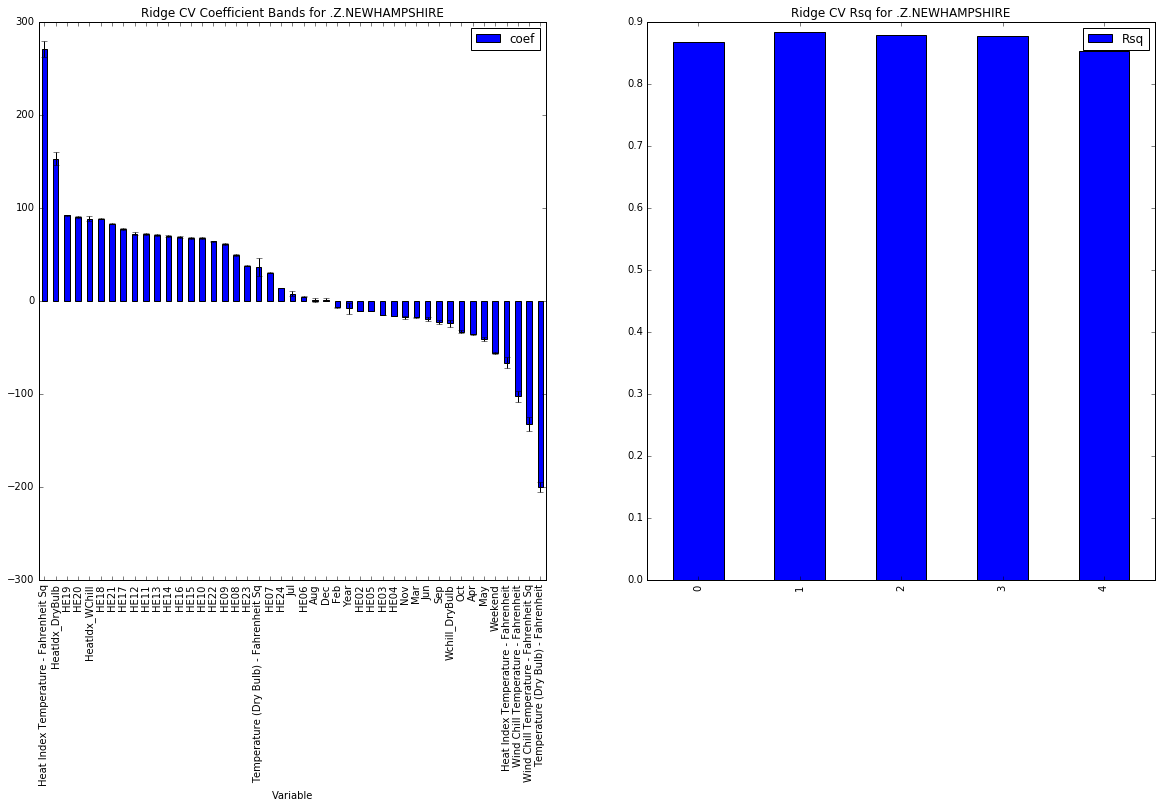

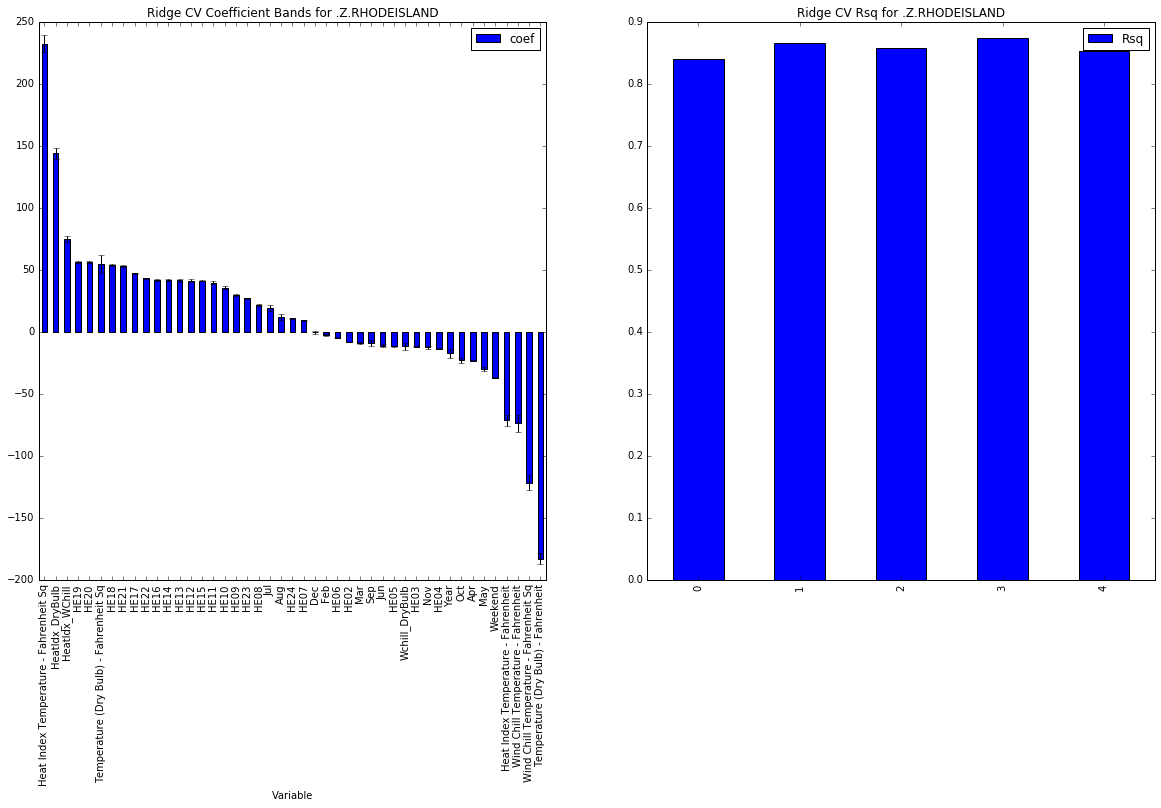

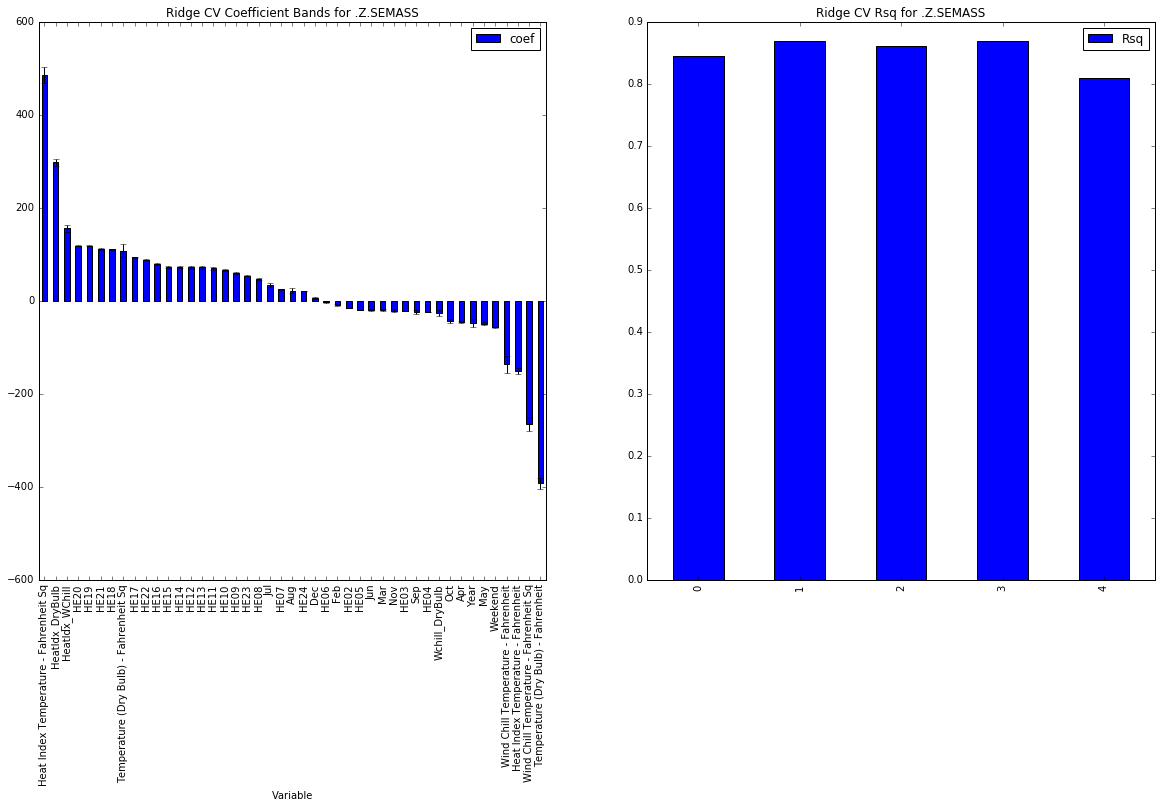

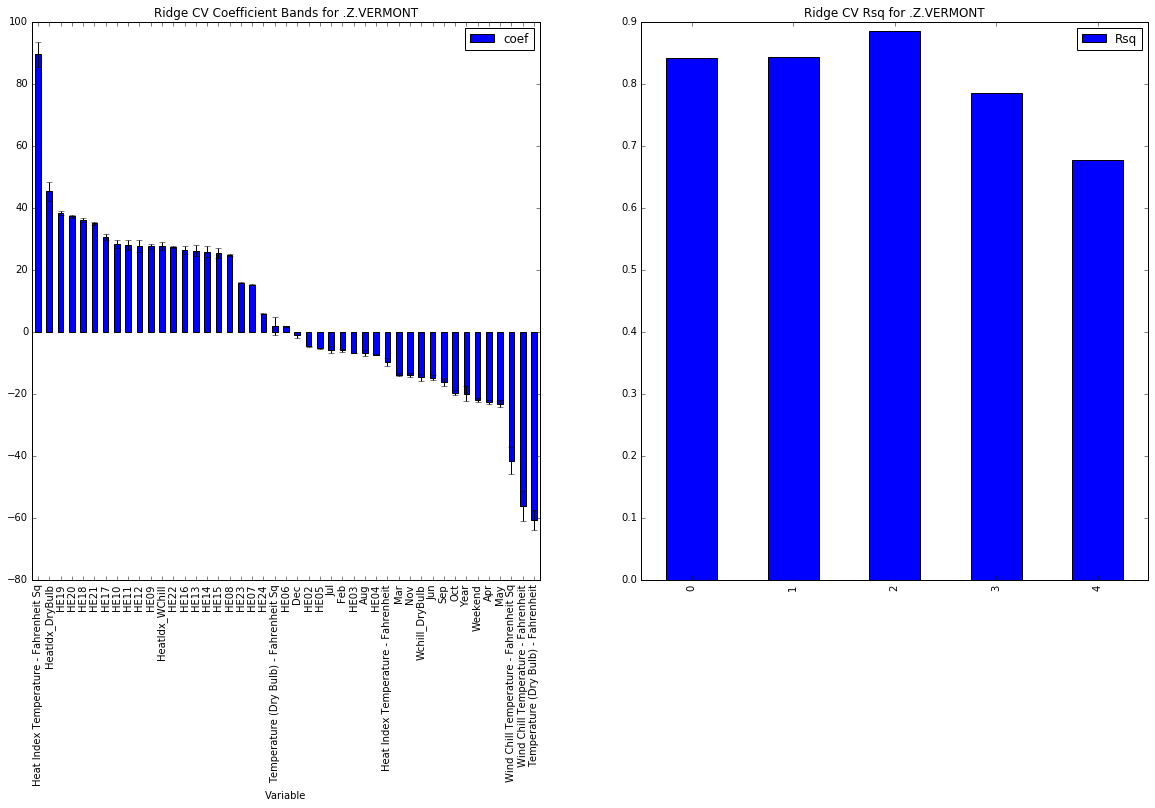

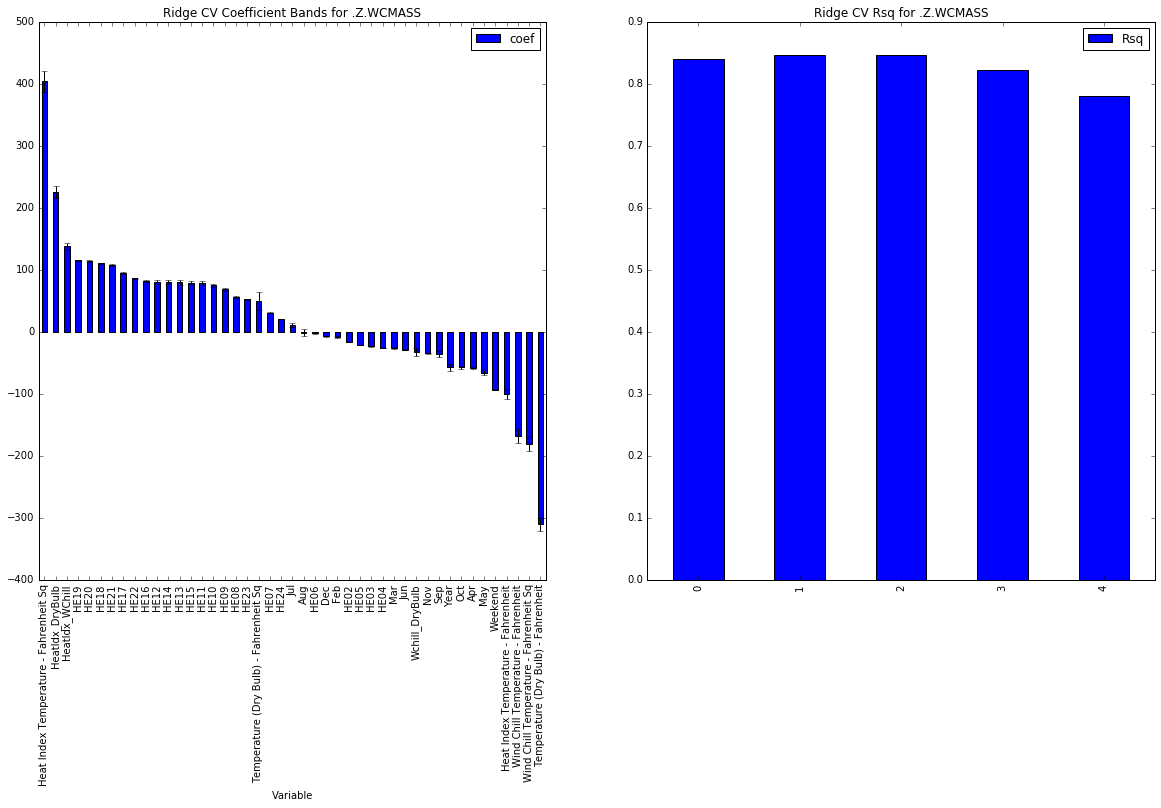

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
for lz in load_zones:
    df = pd.read_hdf(r".\Cleaned Data\regression_df.hdf",lz)

    for t in temp_cols:
        df[t + " Sq"] = df[t]**2.0
    df["Wchill_DryBulb"] = df[temp_cols[0]]*df[temp_cols[2]]
    df["HeatIdx_DryBulb"] = df[temp_cols[0]]*df[temp_cols[1]]
    df["HeatIdx_WChill"] = df[temp_cols[1]]*df[temp_cols[2]]
    
    regression_vars = seasonal_variables + weather_vars[-6:] + ["Wchill_DryBulb","HeatIdx_DryBulb","HeatIdx_WChill"]
    X = StandardScaler().fit_transform(df[regression_vars])
    y = df[lz]
    
    
    fig,ax = plt.subplots(1,2,figsize=(20,10))
    coeffs, scores = run_cv_coeffs(X,y.values,Ridge,alpha=100.0,fit_intercept=True)
    
    coeffs = np.array(coeffs)
    coeffs_avg,coeffs_std=get_coeffs(coeffs)
    
    dfCoeffs = pd.DataFrame({'type':regression_vars, 'coef':coeffs_avg, 'std':coeffs_std})
    dfCoeffs_sorted = dfCoeffs.sort_values(['coef'])[::-1]
    yerr_vals = dfCoeffs_sorted['std'].values

    dfCoeffs_sorted.plot(x='type',y='coef',kind='bar',yerr=yerr_vals,ax=ax[0])
    ax[0].set_title("Ridge CV Coefficient Bands for {}".format(lz))
    ax[0].set_xlabel("Variable")

    rsq_df = pd.DataFrame({'Fold':["CV%d"%d for d in range(5)], 'Rsq':scores})
    rsq_df.plot(ax=ax[1],kind="bar",title="Ridge CV Rsq for {}".format(lz))

    plt.show()

## Comparison with Random Forest

Comparing our results to Random Forest Regression, we get similar R squareds.  This is reinforcing of our confidence in this model.

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
for lz in load_zones[:1]:
    df = pd.read_hdf(r".\Cleaned Data\regression_df.hdf",lz)

    for t in temp_cols:
        df[t + " Sq"] = df[t]**2.0
    df["Wchill_DryBulb"] = df[temp_cols[0]]*df[temp_cols[2]]
    df["HeatIdx_DryBulb"] = df[temp_cols[0]]*df[temp_cols[1]]
    df["HeatIdx_WChill"] = df[temp_cols[1]]*df[temp_cols[2]]
    
    regression_vars = seasonal_variables + weather_vars[-6:] + ["Wchill_DryBulb","HeatIdx_DryBulb","HeatIdx_WChill"]
    Xstd = StandardScaler().fit_transform(df[regression_vars])
    X = df[regression_vars]
    y = df[lz]
    
    ridge_reg = GridSearchCV(Ridge(),{"alpha":[10.0],"fit_intercept":[True]},cv=5)
    ridge_reg.fit(Xstd,y)
    
    kf = KFold(len(y),n_folds=5,shuffle=False)
    y_pred = y.copy()
    scores=[]
    # Iterate through folds
    for train_index, test_index in kf:        
        X_train, X_test = X.values[train_index], X.values[test_index]
        r_forest = RandomForestRegressor()
        r_forest.fit(X_train,y[train_index])
        scores.append(r_forest.score(X_test,y[test_index]))


In [21]:


final_cv_rsq =\
pd.DataFrame({'CV Split/Folds':range(5), 
              'Ridge Regression':[ridge_reg.cv_results_['split{}_test_score'.format(i)][0] for i in range(5)], 
              'Random Forest (No Std)':scores})
# final_cv_rsq[['Ridge Regression','Random Forest (No Std)']].plot(kind="bar")
# plt.legend(loc="best")
# plt.show()
final_cv_rsq = final_cv_rsq.groupby('CV Split/Folds').mean()
final_cv_rsq

,Random Forest (No Std),Ridge Regression
CV Split/Folds,,
0,0.867167,0.848849
1,0.893919,0.883915
2,0.881647,0.872130
3,0.873431,0.881294
4,0.852941,0.849148


# Final Forecast Model

In [22]:
predictive_load_model = dict()
std_scalar_transform = dict()
lz_ws_mapping = pd.read_hdf(r".\Cleaned Data\lz_ws_mapping.hdf")
load_zones = lz_ws_mapping.columns[1:]

model_trn_scores = pd.DataFrame(index=load_zones,columns=["Training Rsq"])
model_trn_scores.index.name = "Load Zone"

for lz in load_zones:
    df = pd.read_hdf(r".\Cleaned Data\regression_df.hdf",lz)
    
    for t in temp_cols:
        df[t + " Sq"] = df[t]**2.0
    df["Wchill_DryBulb"] = df[temp_cols[0]]*df[temp_cols[2]]
    df["HeatIdx_DryBulb"] = df[temp_cols[0]]*df[temp_cols[1]]
    df["HeatIdx_WChill"] = df[temp_cols[1]]*df[temp_cols[2]]
    
    regression_vars = seasonal_variables + weather_vars[-6:] + ["Wchill_DryBulb","HeatIdx_DryBulb","HeatIdx_WChill"]    
    X = df[regression_vars]
    y = df[lz]
    
#     random_forest_models[lz] = RandomForestRegressor()
#     random_forest_models[lz].fit(X,y)
    
    #Xstd = StandardScaler().fit_transform(X)
    std_scalar_transform[lz] = StandardScaler()
    std_scalar_transform[lz].fit(X)
    Xstd = std_scalar_transform[lz].transform(X)
    
    
    
    predictive_load_model[lz] = GridSearchCV(Ridge(),{"alpha":[10.0],"fit_intercept":[True]},cv=5)
    predictive_load_model[lz].fit(Xstd,y)

    
    model_trn_scores.loc[lz,"Training Rsq"] = predictive_load_model[lz].score(Xstd,y)
model_trn_scores

,Training Rsq
Load Zone,
.Z.CONNECTICUT,0.880555
.Z.MAINE,0.873392
.Z.NEMASSBOST,0.875205
.Z.NEWHAMPSHIRE,0.88873
.Z.RHODEISLAND,0.876928
.Z.SEMASS,0.878547
.Z.VERMONT,0.841571
.Z.WCMASS,0.849255


In [23]:
nws_forecast = pd.read_excel(r".\Cleaned Data\Weather Forecast Update 2018-05-10.xlsx","Import")

st_time = nws_forecast["Local Datetime (Hour Beginning)"].min()
en_time = nws_forecast["Local Datetime (Hour Ending)"].max()
fcast_dtidx = pd.date_range(st_time,en_time,freq="H",closed="left")
fcast_dtidx.name = "Local Datetime (Hour Beginning)"
fcast_df = pd.DataFrame(index=fcast_dtidx)
weather_cols = df.columns[-9:]

for lz in load_zones:
    wstation_wgt = lz_ws_mapping.loc[lz_ws_mapping[lz] > .01,lz]
    agg_temp_df = pd.DataFrame(index=fcast_dtidx,columns=weather_cols,data=0.0,dtype=float)
    agg_temp_df["Weight"] = 0.0

    season_df = pd.DataFrame(index=fcast_dtidx,columns=["Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"] + ["HE%.2d" % h for h in range(2,25)],data=0.0)
    season_df["Year"] = season_df.index.year
    season_df["Weekend"] = 0.0
    season_df.loc[season_df.index.dayofweek > 4,"Weekend"] = 1.0
    cmo_dict = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
    for i in season_df.index:
        if cmo_dict[i.month] != "Jan":
            season_df.loc[i,cmo_dict[i.month]] = 1.0
        if (i.hour + 1) != 1:
            season_df.loc[i,"HE%.2d" % (i.hour + 1)] = 1.0



    for ws in wstation_wgt.index:
        ws_wgt = wstation_wgt.loc[ws]
        wsdata = nws_forecast.loc[nws_forecast["Weather Station Name"] == ws]
        wsdata = wsdata.rename(columns={"Local Datetime (Hour Beginning)":"Interval"})
        ws_contrib = wsdata.groupby("Interval").mean()[weather_cols]*ws_wgt
        ws_contrib = ws_contrib.join(wsdata.groupby("Interval").first()["Local Datetime (Hour Ending)"])
        ws_contrib = ws_contrib.loc[np.isfinite(ws_contrib[weather_cols]).all(axis=1)]

        for i in ws_contrib.index:
            agg_temp_df.loc[
                (agg_temp_df.index >= i)&(agg_temp_df.index < ws_contrib.loc[i,"Local Datetime (Hour Ending)"])
                ,weather_cols] += ws_contrib.loc[i,weather_cols].values
            agg_temp_df.loc[
                (agg_temp_df.index >= i)&(agg_temp_df.index < ws_contrib.loc[i,"Local Datetime (Hour Ending)"])
                ,"Weight"] += ws_wgt



    w_scale = np.array(agg_temp_df["Weight"].values,dtype=float)
    agg_temp_df = (agg_temp_df[weather_cols].divide(w_scale,axis=0))[weather_cols]
    agg_temp_df = agg_temp_df.loc[np.isfinite(agg_temp_df).all(axis=1)]
    regr_df = season_df.join(agg_temp_df,how="inner")
    Xstd = std_scalar_transform[lz].transform(regr_df[regression_vars])
    fcast_load = pd.Series(index=regr_df.index,data=predictive_load_model[lz].predict(Xstd),name=lz)
    fcast_df = fcast_df.join(fcast_load.copy(),how="inner")

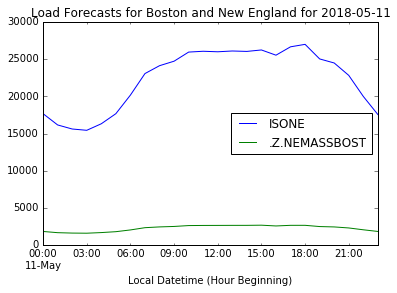

In [25]:
fcast_df["ISONE"] = fcast_df.sum(axis=1)
fcast_df.loc[fcast_df.index.floor("D")==pd.to_datetime("2018-05-11"),"ISONE"].plot()
fcast_df.loc[fcast_df.index.floor("D")==pd.to_datetime("2018-05-11"),".Z.NEMASSBOST"].plot()
plt.legend(loc="best")
plt.title("Load Forecasts for Boston and New England for 2018-05-11")
plt.show()